## Import Libraries and Input Key Functions

In [1]:
# Jupyer Notebook Theme: jt -t monokai -f fira -fs 10 -nf ptsans -nfs 11 -N -kl -cursw 2 -cursc r -cellw 95% -T
# Check python version
import sys
cdPyVer = 0x600
cdSysVer = sys.version[:5]
print("%s%s" %("My python version is: ", cdSysVer)) # strangely it works only on 3.7.4 and not 3.7.6

# Import libraries
import pandas as pd 
import numpy as np
import warnings

# Progress Bar
from tqdm.auto import tqdm

# Visualisation Libraries
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.gridspec import GridSpec
plt.style.use('seaborn-dark') # use this theme as you are using dark theme in the notebook
import seaborn as sns
import folium
from folium.plugins import HeatMap, FastMarkerCluster

# Utility Modules
sys.path.append('/Users/Shandeep/data_science/delivery_hero')


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
              
warnings.filterwarnings('ignore')

My python version is: 3.9.7


## Connection to BigQuery

In [2]:
"""
Connect to big query and then run analysis acordingly.
"""

import sys
sys.path.append('/Users/Shandeep/qc_data_insights/utils/') # git clone this repository qc_data_insights
from utils import utils

import os
from google.oauth2 import service_account
# pip install google-cloud-bigquery==1.24.0 # requires this version.. current version is bugged with pandas
from google.cloud import bigquery

google_credentials_path = os.path.expanduser('~')+'/Documents/google_cloud_data-insights-team.json' # make sure add json file credentials in documents folder
credentials = service_account.Credentials.from_service_account_file(google_credentials_path)
bqclient = bigquery.Client(credentials=credentials, project=credentials.project_id)
print(f'Connected to BigQuery, project: {bqclient.project} on version {bigquery.__version__}')
print(f'Service Account Email: {bqclient.get_service_account_email()}')

Connected to BigQuery, project: dh-darkstores-live on version 1.24.0
Service Account Email: bq-1010543247368@bigquery-encryption.iam.gserviceaccount.com


## Table Information

In [3]:
from utils import qa
project = 'dh-darkstores-live'
dataset = 'cl_data_science_qcommerce'
table   = '_promo_roi_out_roi_tableau_report'

t = bqclient.get_table(f'{project}.{dataset}.{table}')
print(f'Table: {project}.{dataset}.{table}')
print("____________________________________________________________________")
print("")
print(qa.bq_table_info(bqclient, project, dataset, table))

Table: dh-darkstores-live.cl_data_science_qcommerce._promo_roi_out_roi_tableau_report
____________________________________________________________________

type:           TABLE
row count:      3,637,475
column count:   38
size:           1.42 GB
table created:  2021-12-08 23:18:19
last modified:  2021-12-08 23:18:19
description:    Promo ROI Model Tableau Report
labels:         {}
partitioned by: DAY
GCP location:   US
None


#### Schema

In [4]:
schema_df = qa.bq_schema_df(bqclient, project, dataset, table)
print(schema_df.groupby('type')['name'].count()) 
schema_df

type
BOOLEAN       1
DATE          2
FLOAT        17
INTEGER       1
STRING       14
TIMESTAMP     3
Name: name, dtype: int64


,name,type,mode,description
0,order_date,DATE,NULLABLE,None
1,global_entity_id,STRING,NULLABLE,None
2,warehouse,STRING,NULLABLE,None
3,supplier,STRING,NULLABLE,None
4,sku,STRING,NULLABLE,None
5,no_of_campaigns,INTEGER,NULLABLE,None
6,campaign_id,STRING,NULLABLE,None
7,campaign_name,STRING,NULLABLE,None
8,campaign_created_time_utc,TIMESTAMP,NULLABLE,None
9,campaign_start_time_utc,TIMESTAMP,NULLABLE,None


#### Column types

In [5]:
cols_numeric  = schema_df.loc[schema_df['type'].isin(['FLOAT', 'INTEGER', 'NUMERIC']),   'name'].values
cols_datetime = schema_df.loc[schema_df['type'].isin(['DATE', 'DATETIME', 'TIMESTAMP']), 'name'].values
cols_boolean  = schema_df.loc[schema_df['type'].isin(['BOOLEAN']),                       'name'].values
cols_object   = schema_df.loc[schema_df['type'].isin(['STRING', ]),                      'name'].values

In [6]:
# Some types are not supported by pandas
cols_not_supported = schema_df.loc[schema_df['type']=='RECORD', 'name'].values
cols_not_supported

array([], dtype=object)

#### Query

#### Main Query

In [7]:
# WHERE RAND() < 10000/{t.num_rows} --- Add this if you are looking for 100000 random row
query =f""" 
SELECT *
FROM `{project}.{dataset}.{table}`
WHERE RAND() < 10000/{t.num_rows}
"""
# Read query and display in the form of a pandas dataframe
df = utils.read_bigquery(query, bqclient, parse_dates=[], verbose=True)
df.head()

running query... job done, downloading... 

Downloading:   0%|          | 0/9838 [00:00<?, ?rows/s]

done with shape (9838, 38)


,order_date,global_entity_id,warehouse,supplier,sku,no_of_campaigns,campaign_id,campaign_name,campaign_created_time_utc,campaign_start_time_utc,campaign_end_time_utc,is_campaign_active,category,subcategory,brand,product,y_pred_base,y_pred,b_qty,qty_sold,incremental_quantity_tab,is_outlier_incremental_quantity,price_base,price,cost,b_gmv,gmv,incremental_gmv_tab,is_outlier_incremental_gmv,b_profit,profit,profit_ext,incremental_profit_ext_tab,is_outlier_incremental_profit_ext,execution_date,confidence,discount,externally_funded_percentage
0,2020-11-03,FP_HK,Mong Kok,Rich Harvest Agricultural Produce Ltd,395AN5,1,de0186d0-e9f4-4253-9759-194ee04a2bd2,Rich Harvest - Nov,2020-10-31 16:24:31+00:00,2020-10-31 17:00:00+00:00,2020-11-30 16:00:00+00:00,True,Fresh Produce,Vegetables,Green Farmer,Green Farmer - Red Onion 250g,4.63,6.94,2.00,3.0,50.000000,No,6.90,4.90,3.00,13.81,14.70,6.444605,No,7.80,5.70,11.70,50.000000,No,2021-12-08,high,29.0,100.0
1,2020-11-03,FP_SG,Whampoa,Toll Distribution Center,6OC459,2,41d1ef61-3cf8-4417-87c1-08e216c8a74d,02-Nov-2020-15-Nov-2020,2020-11-01 13:20:00+00:00,2020-11-01 16:00:00+00:00,2020-11-15 16:00:00+00:00,True,"Wine, Beer, Spirits",Beer (Multipack),Kronenbourg 1664,Kronenbourg 1664 Lager Can 4s x 330ml,2.14,2.89,1.48,2.0,35.135135,No,12.90,10.50,10.67,19.12,21.00,9.832636,No,3.31,-0.34,-0.34,-110.271903,No,2021-12-08,very high,19.0,0.0
2,2020-11-03,FP_SG,Whampoa,Toll Distribution Center,D28LEI,1,84d12cc5-0fc9-47ef-b0aa-d3f86999b034,01-Sep-2020-31-Dec-2020 [Dawood],2020-08-28 09:46:35+00:00,2020-08-31 16:00:00+00:00,2020-12-31 16:00:00+00:00,True,Beverages,Water,San Benedetto,San Benedetto Natural Mineral Water 1.5L,8.14,22.44,13.05,36.0,175.862069,Yes,2.00,1.00,1.45,26.11,36.00,37.878208,No,7.18,-16.20,-16.20,-325.626741,Yes,2021-11-04,high,50.0,0.0
3,2020-11-03,FP_SG,Bukit Batok,Lotte Confectionery (S.E.A) Pte Ltd,8HL8MX,1,43f5892e-22de-4f94-82ad-a6eb741429d8,05-Oct-2020-30-Nov-2020 [Lotte][final],2020-10-05 04:41:56+00:00,2020-10-05 04:00:00+00:00,2020-11-30 16:00:00+00:00,True,"Biscuit, Crackers & Cookies",Sticks & Dips,Lotte,Lotte Pepero Choco Cookie 32g,2.09,3.07,4.08,6.0,47.058824,No,1.30,1.10,0.95,5.31,6.60,24.293785,No,1.43,0.90,0.90,-37.062937,No,2021-12-08,medium,15.0,0.0
4,2020-07-06,FP_SG,Yishun,Crown Pacific Beverage Pte Ltd (Ambient),R70IVU,1,37a0cb6f-d5de-483f-a43e-b58b78069b97,w28_breakfast,2020-07-05 08:24:25+00:00,2020-07-05 16:00:00+00:00,2020-07-12 16:00:00+00:00,True,"Dairy, Chilled & Eggs",Soy & Milk Alternatives,Vitasoy,Vitasoy Less Sugar Soy Drink Pack 6s x 250ml,2.45,3.31,5.18,7.0,35.135135,No,3.15,2.98,2.65,16.32,20.86,27.818627,No,2.59,2.31,3.50,35.135135,No,2021-11-24,very high,5.0,100.0


#### Exploring the idea of Stratified Sampling

In [8]:
# Number of global entity ids in dataset 
query =f""" 
SELECT global_entity_id, COUNT(*) AS num_of_rows
FROM `{project}.{dataset}.{table}`
GROUP BY 1
ORDER BY 2 DESC
"""
# Read query and display in the form of a pandas dataframe
country_count = utils.read_bigquery(query, bqclient, parse_dates=[], verbose=True)
country_count

running query... job done, downloading... 

Downloading:   0%|          | 0/12 [00:00<?, ?rows/s]

done with shape (12, 2)


,global_entity_id,num_of_rows
0,FP_SG,772229
1,FP_HK,514732
2,FP_MY,500616
3,FP_TW,481346
4,FP_TH,428984
5,HS_SA,240317
6,FP_BD,209794
7,FP_PK,207817
8,TB_AE,188234
9,HF_EG,84929


In [9]:
"""
The problem with the query above is that it does random sampling without taking stratified
sampling into account, what that means is that certain countries have huge representation. Fix
this with a stratified sampling such that we have the same number of countries in our representation.
Suppose we want 500 random rows for each global entity id
"""
query =f""" 
SELECT t.*
FROM (SELECT t.*,
             ROW_NUMBER() OVER(Partition BY global_entity_id ORDER BY RAND()) as seqnum
      from `{project}.{dataset}.{table}` t
     ) t
WHERE seqnum <= 500;
"""
# Read query and display in the form of a pandas dataframe
ss = utils.read_bigquery(query, bqclient, parse_dates=[], verbose=True)
ss.head()

running query... job done, downloading... 

Downloading:   0%|          | 0/6000 [00:00<?, ?rows/s]

done with shape (6000, 39)


,order_date,global_entity_id,warehouse,supplier,sku,no_of_campaigns,campaign_id,campaign_name,campaign_created_time_utc,campaign_start_time_utc,campaign_end_time_utc,is_campaign_active,category,subcategory,brand,product,y_pred_base,y_pred,b_qty,qty_sold,incremental_quantity_tab,is_outlier_incremental_quantity,price_base,price,cost,b_gmv,gmv,incremental_gmv_tab,is_outlier_incremental_gmv,b_profit,profit,profit_ext,incremental_profit_ext_tab,is_outlier_incremental_profit_ext,execution_date,confidence,discount,externally_funded_percentage,seqnum
0,2021-06-24,PO_FI,Pasila,Satotukku,6405940117919,1,50f2212a-b966-4042-8945-c0c7e3255800,"Foodora Market banaanit 0,79€ ver3",2021-06-14 11:44:49+00:00,2021-06-14 12:00:00+00:00,2021-06-30 19:00:00+00:00,True,Fruits & Vegetables,Fruits & Berries,Satotukku,Banana 1 kg,8.10,15.91,9.68,19.0,96.280992,No,1.49,0.79,1.44,14.42,15.01,4.091540,No,0.48,-12.35,-12.35,-2672.916667,Yes,2021-11-25,medium,47.0,0.0,13
1,2021-08-13,PO_FI,Niittykumpu,Hk Scan,6409100076405,1,9a64af1d-a017-46af-886f-d4a9386fecbc,Foodora Market NII hävikkitori 13.8.,2021-08-13 08:47:07+00:00,2021-08-13 09:00:00+00:00,2021-08-15 19:00:00+00:00,True,Ready meals & Snacks,Ready meals,NA,Mäkitalon Farmi Chicken-caesar salad 210g,1.86,3.32,3.36,6.0,78.571429,No,3.99,2.55,2.48,13.40,15.30,14.179104,No,5.07,0.42,0.42,-91.715976,No,2021-12-08,medium,36.0,0.0,71
2,2021-06-20,PO_FI,Herttoniemi,Satotukku,6405940117919,1,50f2212a-b966-4042-8945-c0c7e3255800,"Foodora Market banaanit 0,79€ ver3",2021-06-14 11:44:49+00:00,2021-06-14 12:00:00+00:00,2021-06-30 19:00:00+00:00,True,Fruits & Vegetables,Fruits & Berries,Satotukku,Banana 1 kg,7.57,14.87,11.72,23.0,96.245734,No,1.49,0.79,1.44,17.46,18.17,4.066438,No,0.59,-14.95,-14.95,-2633.898305,Yes,2021-11-25,medium,47.0,0.0,81
3,2021-06-16,PO_FI,Tampere,Satotukku,6405940117919,1,ddcb8120-fc26-4913-9436-5014d0de2638,"Foodora Market banaanit 0,79€ TRE ver2",2021-06-14 11:45:26+00:00,2021-06-14 12:00:00+00:00,2021-06-30 19:00:00+00:00,True,Fruits & Vegetables,Fruits & Berries,Satotukku,Banana 1 kg,7.12,13.98,7.64,15.0,96.335079,No,1.49,0.79,1.44,11.39,11.85,4.038630,No,0.38,-9.75,-9.75,-2665.789474,Yes,2021-11-25,medium,47.0,0.0,106
4,2021-10-14,PO_FI,Malmi,Satotukku,EMF6WX,1,882b65c3-c7bc-49bb-afe4-3db88c209522,Foodora Market MAL hävikkitori 14.10.,2021-10-14 09:00:13+00:00,2021-10-14 09:00:00+00:00,2021-10-15 06:25:15+00:00,False,Fruits & Vegetables,Fruits & Berries,Satotukku,Black grapes 500g,4.77,9.31,7.67,15.0,95.567145,No,2.20,1.37,1.45,16.88,20.55,21.741706,No,5.76,-1.20,-1.20,-120.833333,No,2021-12-01,medium,38.0,0.0,171


#### Country Representation in Dataset

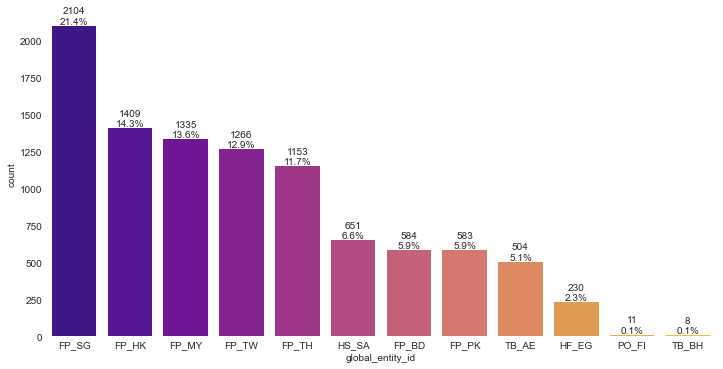

In [10]:
# Orignal dataframe representation
from utils import viz_utils
fig, ax = plt.subplots(figsize=(12, 6))
viz_utils.single_countplot(df, x='global_entity_id', ax=ax)
plt.show()

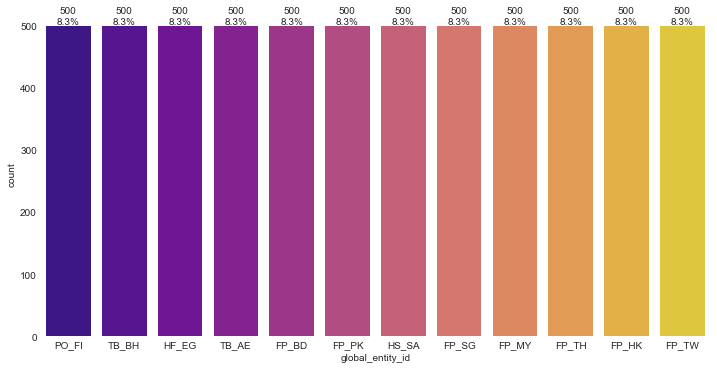

In [11]:
# The difference when you do stratified sampling!
fig, ax = plt.subplots(figsize=(12, 6))
viz_utils.single_countplot(ss, x='global_entity_id', ax=ax)
plt.show()

#### Quantity Sold by Order Date

In [20]:
ma = df.groupby(by='order_date', as_index=False).agg({'qty_sold': 'sum'})
ma.columns = ['order_date','qty_sold']
ma = ma.sort_values(by='order_date')
ma = ma.loc[:, ['order_date','qty_sold']].reset_index(drop=True)
ma.head()

,order_date,qty_sold
0,2019-12-28,3.0
1,2020-01-18,2.0
2,2020-01-24,2.0
3,2020-01-26,1.0
4,2020-01-30,2.0


Text(0.5, 1.03, 'Datapoints by Date')

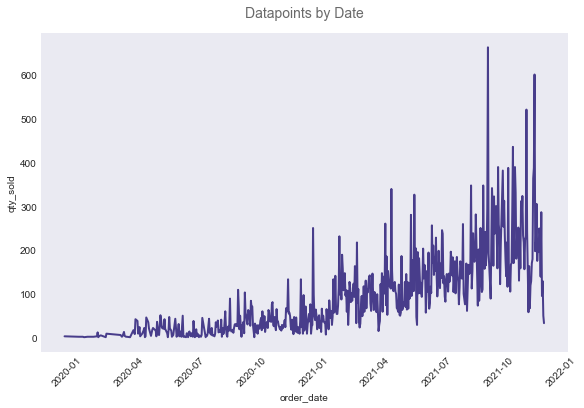

In [21]:
fig = plt.figure(constrained_layout=True, figsize=(8, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])


# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=ma, x = 'order_date', y='qty_sold', ax=ax1, 
             color='darkslateblue', linewidth=2)

for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Datapoints by Date', y = 1.03, size=14, color='dimgrey')

#### Moving Average

In [23]:
# Lets look at the 7 day rolling average for quantity sold!
ma['qty_sold_rolling_avg'] = ma['qty_sold'].rolling(7).mean()
ma.head(8)

,order_date,qty_sold,qty_sold_rolling_avg
0,2019-12-28,3.0,NaN
1,2020-01-18,2.0,NaN
2,2020-01-24,2.0,NaN
3,2020-01-26,1.0,NaN
4,2020-01-30,2.0,NaN
5,2020-01-31,2.0,NaN
6,2020-02-01,2.0,2.000000
7,2020-02-09,2.0,1.857143


Text(0.5, 1.03, 'Datapoints by Date')

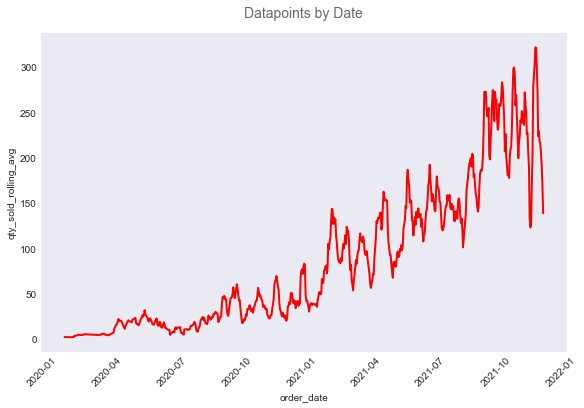

In [24]:
fig = plt.figure(constrained_layout=True, figsize=(8, 10))

# Axis definition
gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])


# Lineplot - Evolution of e-commerce orders along time 
sns.lineplot(data=ma, x = 'order_date', y='qty_sold_rolling_avg', ax=ax1, 
             color='red', linewidth=2)

for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
ax1.set_title('Datapoints by Date', y = 1.03, size=14, color='dimgrey')

In [15]:
df[df.duplicated()].head()# don't know why it's not working as expected

,order_date,global_entity_id,warehouse,supplier,sku,no_of_campaigns,campaign_id,campaign_name,campaign_created_time_utc,campaign_start_time_utc,campaign_end_time_utc,is_campaign_active,category,subcategory,brand,product,y_pred_base,y_pred,b_qty,qty_sold,incremental_quantity_tab,is_outlier_incremental_quantity,price_base,price,cost,b_gmv,gmv,incremental_gmv_tab,is_outlier_incremental_gmv,b_profit,profit,profit_ext,incremental_profit_ext_tab,is_outlier_incremental_profit_ext,execution_date,confidence,discount,externally_funded_percentage


#### Data types

In [16]:
df.dtypes

order_date                                        object
global_entity_id                                  object
warehouse                                         object
supplier                                          object
sku                                               object
no_of_campaigns                                    int64
campaign_id                                       object
campaign_name                                     object
campaign_created_time_utc            datetime64[ns, UTC]
campaign_start_time_utc              datetime64[ns, UTC]
campaign_end_time_utc                datetime64[ns, UTC]
is_campaign_active                                  bool
category                                          object
subcategory                                       object
brand                                             object
product                                           object
y_pred_base                                      float64
y_pred                         

In [17]:
cols_numeric

array(['no_of_campaigns', 'y_pred_base', 'y_pred', 'b_qty', 'qty_sold',
       'incremental_quantity_tab', 'price_base', 'price', 'cost', 'b_gmv',
       'gmv', 'incremental_gmv_tab', 'b_profit', 'profit', 'profit_ext',
       'incremental_profit_ext_tab', 'discount',
       'externally_funded_percentage'], dtype=object)

In [18]:
cols_object

array(['global_entity_id', 'warehouse', 'supplier', 'sku', 'campaign_id',
       'campaign_name', 'category', 'subcategory', 'brand', 'product',
       'is_outlier_incremental_quantity', 'is_outlier_incremental_gmv',
       'is_outlier_incremental_profit_ext', 'confidence'], dtype=object)

In [19]:
for col in cols_numeric:
    df[col] = pd.to_numeric(df[col], errors='raise')

cols_numeric_2 = ['no_of_campaigns', 'y_pred_base', 'y_pred', 'b_qty', 'qty_sold',
       'incremental_quantity_tab', 'price_base', 'price', 'cost', 'b_gmv',
       'gmv', 'incremental_gmv_tab', 'b_profit', 'profit', 'profit_ext',
       'incremental_profit_ext_tab', 'discount',
       'externally_funded_percentage']
    
for col in cols_numeric_2:
    df[col] = pd.to_numeric(df[col], errors='raise')

for col in cols_datetime:
    df[col] = pd.to_datetime(df[col], errors='raise').dt.date

for col in cols_boolean:
    df[col] = df[col].astype(bool)

In [20]:
# Convert object types to date
date_columns = [columns for columns in df.columns if 'date' in columns or 'time' in columns]
print(date_columns)
for col in date_columns:
    df[col] = pd.to_datetime(df[col]).dt.date
df['number_of_campaign_days'] = (df['campaign_end_time_utc'] - df['campaign_start_time_utc']).dt.days

['order_date', 'campaign_created_time_utc', 'campaign_start_time_utc', 'campaign_end_time_utc', 'execution_date']


### Dataset deep dive

In [21]:
utils.df_info(df).style.background_gradient(subset=['isnull_%'], cmap='Reds')

,column,dtype,memory_mb,nunique,notnull,isnull,isnull_%,min,max
0,order_date,object,0.410000,604,10139,0,0.000000,2020-01-22,2021-12-07
1,global_entity_id,object,0.630000,12,10139,0,0.000000,FP_BD,TB_BH
2,warehouse,object,0.750000,338,10139,0,0.000000,6th Of October - 4th District,熊貓超市(高雄三民店)
3,supplier,object,0.980000,616,10139,0,0.000000,Kao (Hong Kong) Limited,lfad Multi Products Ltd
4,sku,object,0.640000,3288,10139,0,0.000000,00011F,ZZX8I1
5,no_of_campaigns,int64,0.080000,14,10139,0,0.000000,1,24
6,campaign_id,object,0.940000,3902,10139,0,0.000000,0014077a-5f67-4455-99a7-06de3d486b53,ffffd406-76bd-48dd-ac64-00b71c8450d6
7,campaign_name,object,0.940000,3652,10139,0,0.000000,(IATCO) Kinder - Sep,w24_hero1_ncr_brandweek_dksh_flash_tier1_day3
8,campaign_created_time_utc,object,0.410000,519,10139,0,0.000000,2020-01-02,2021-12-06
9,campaign_start_time_utc,object,0.410000,524,10139,0,0.000000,2020-01-02,2021-12-06


In [22]:
# Check out why it is null
# (price base - cost) * b_qty = b_profit
df[df.incremental_profit_ext_tab.isna()][['price_base','cost','b_qty','b_profit','profit_ext','incremental_profit_ext_tab']].head()

,price_base,cost,b_qty,b_profit,profit_ext,incremental_profit_ext_tab
2652,52.0,52.0,4.32,0.0,-78.00,NaN
3390,44.0,44.0,21.98,0.0,-594.00,NaN
6865,125.0,125.0,11.07,0.0,-369.20,NaN
7266,120.0,120.0,13.29,0.0,-426.24,NaN
7465,125.0,125.0,9.22,0.0,-282.72,NaN


#### Category Insights

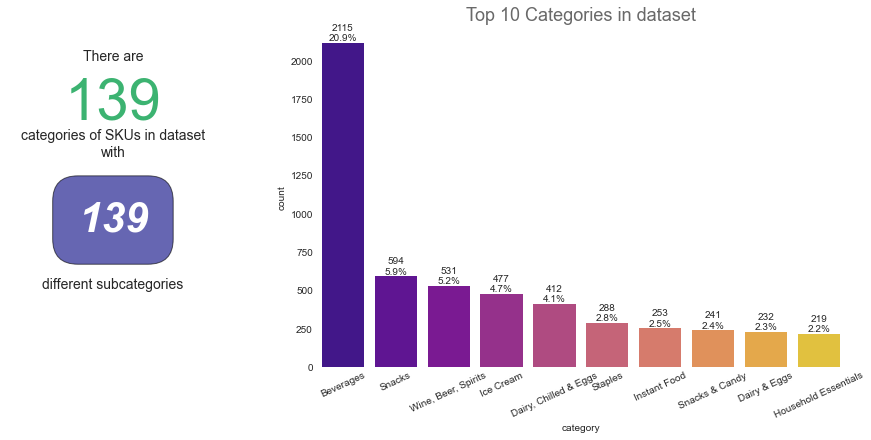

In [23]:
# Building a figure
fig = plt.figure(constrained_layout=True, figsize=(12, 6))

# Axis definition with GridSpec
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1:3])

# Axis 1 - Big Number for total categories and subcategories in the data
total_categories = len(df['category'].value_counts())
total_subcategories = len(df['category'].value_counts())
ax1.text(0.4, 0.9, 'There are', fontsize=14, ha='center')
ax1.text(0.4, 0.73, f'{total_categories}', fontsize=58, color='mediumseagreen', ha='center')
ax1.text(0.4, 0.62, f'categories of SKUs in dataset\nwith', fontsize=14, ha='center')
ax1.text(0.4, 0.4, total_subcategories, fontsize=42, ha='center', color='white', style='italic', weight='bold',
         bbox=dict(facecolor='navy', alpha=0.6, pad=16, boxstyle='round, pad=.6'))
ax1.text(0.4, 0.23, 'different subcategories', fontsize=14, ha='center')
ax1.axis('off')

# Axis 2 - Total number of subcategories
top = 10
viz_utils.single_countplot(df, ax2, x='category', top=top)
ax2.set_title(f'Top {top} Categories in dataset', color='dimgrey', size=18)
for tick in ax2.get_xticklabels():
    tick.set_rotation(25)

In [24]:
popular_categories = df.groupby(by='category', as_index=False).agg({'sku': 'count',
                                                                                    'gmv': 'mean',
                                                                                    'qty_sold': 'mean',
                                                                                    'profit': 'mean',
                                                                                    'externally_funded_percentage': 'mean'})
popular_categories.columns = ['category', 'total_skus', 'mean_gmv', 'mean_qty_sold', 'mean_profit', 'mean_supplier_finding']
popular_categories = popular_categories.sort_values(by='mean_qty_sold', ascending=False)
popular_categories = popular_categories.loc[:, ['category', 'total_skus', 'mean_gmv', 'mean_qty_sold', 'mean_profit', 'mean_supplier_finding']]
popular_categories.head()

,category,total_skus,mean_gmv,mean_qty_sold,mean_profit,mean_supplier_finding
49,Dairy Products,36,3100.904167,24.972222,90.348333,16.666667
135,Water,96,137.053333,22.989583,23.311250,4.166667
96,"Meat, Fruits & Vegetables",20,880.210000,19.000000,-26.561500,0.000000
110,Pet,1,68.850000,17.000000,29.920000,100.000000
34,Cleaning Needs,45,973.942222,14.333333,-3.919333,43.644444


#### Boolean Columns

In [25]:
cols_boolean

array(['is_campaign_active'], dtype=object)

In [26]:
# Columns that start with "is"
print(df.filter(regex='^is',axis=1).columns)

Index(['is_campaign_active', 'is_outlier_incremental_quantity',
       'is_outlier_incremental_gmv', 'is_outlier_incremental_profit_ext'],
      dtype='object')


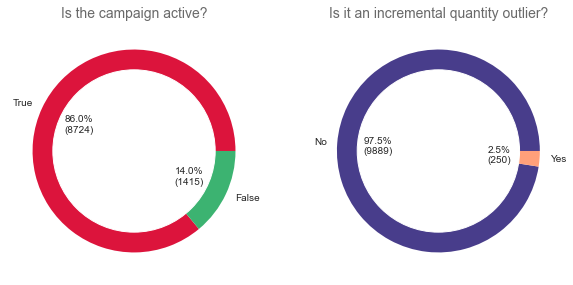

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
viz_utils.donut_plot(df, col='is_campaign_active', colors=['crimson', 'mediumseagreen'], ax=axs[0], 
           title='Is the campaign active?')
viz_utils.donut_plot(df, col='is_outlier_incremental_quantity', colors=['darkslateblue', 'lightsalmon'], ax=axs[1], 
           title='Is it an incremental quantity outlier?')

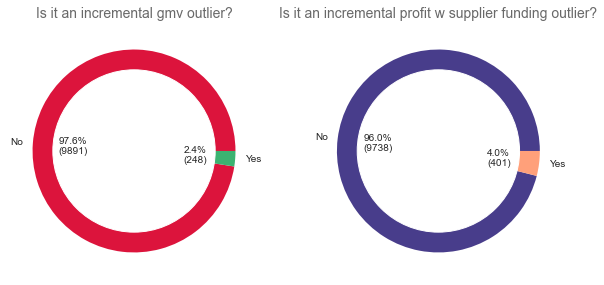

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 10))
viz_utils.donut_plot(df, col='is_outlier_incremental_gmv', colors=['crimson', 'mediumseagreen'], ax=axs[0], 
           title='Is it an incremental gmv outlier?')
viz_utils.donut_plot(df, col='is_outlier_incremental_profit_ext', colors=['darkslateblue', 'lightsalmon'], ax=axs[1], 
           title='Is it an incremental profit w supplier funding outlier?')

### Numerical Columns

In [29]:
# Add number of campaign days to colums_numeric
cols_numeric = np.append(cols_numeric,['number_of_campaign_days'])

# Look at values based on percentiles
desc = df.loc[:, cols_numeric].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])
for col in desc.columns:
    desc[col] = np.round(desc[col], 2)
    
utils.display_df(desc)

,no_of_campaigns,y_pred_base,y_pred,b_qty,qty_sold,incremental_quantity_tab,price_base,price,cost,b_gmv,gmv,incremental_gmv_tab,b_profit,profit,profit_ext,incremental_profit_ext_tab,discount,externally_funded_percentage,number_of_campaign_days
count,10139.00,10139.00,10139.00,10139.00,10139.00,10139.00,10139.00,10139.00,10139.00,10139.00,10139.00,10139.00,10139.00,10139.00,10139.00,10133.00,10139.00,10139.00,10139.00
mean,1.71,3.88,5.75,3.94,5.84,50.51,40.34,34.72,30.02,140.46,175.32,24.13,31.51,17.60,26.84,-8.07,15.01,51.78,61.62
std,1.36,5.45,8.91,6.61,10.76,88.10,80.12,71.47,63.82,456.20,581.35,46.39,81.57,96.32,112.02,168.19,9.67,45.68,1070.24
min,1.00,0.27,0.56,0.15,1.00,1.01,0.27,0.25,0.01,0.26,0.70,0.00,-1304.29,-5277.32,-5277.32,-8544.12,1.00,0.00,0.00
1%,1.00,0.84,1.24,0.45,1.00,5.26,1.15,0.90,0.82,1.22,1.41,0.21,0.25,-50.51,-31.03,-313.03,2.00,0.00,0.00
5%,1.00,1.13,1.56,0.64,1.00,9.89,1.50,1.35,1.16,2.75,3.28,1.29,0.61,-4.50,-0.60,-118.68,4.00,0.00,1.00
10%,1.00,1.31,1.77,0.74,1.00,13.31,2.20,1.89,1.67,4.49,5.40,2.77,1.07,-0.75,0.41,-75.39,5.00,0.00,3.00
25%,1.00,1.67,2.32,0.98,2.00,20.97,5.37,4.41,3.86,11.53,13.78,6.94,2.62,0.63,2.08,-25.04,9.00,0.00,6.00
50%,1.00,2.45,3.52,2.21,3.00,35.14,15.90,13.67,11.51,34.64,41.80,15.14,8.14,3.68,7.44,8.55,13.00,70.00,11.00
75%,2.00,4.03,6.01,4.31,6.00,58.73,40.00,35.00,28.79,105.01,129.68,28.75,26.50,16.50,24.70,30.23,20.00,100.00,23.00


#### Numerical Distributions

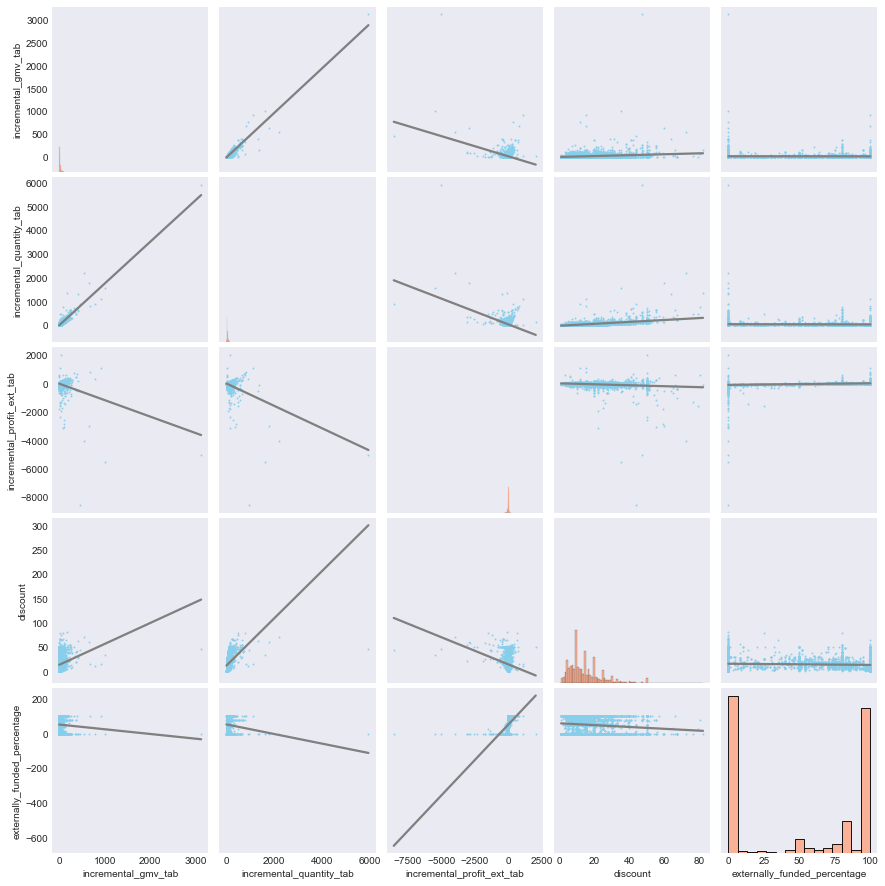

In [30]:
sns.pairplot(df, vars = ['incremental_gmv_tab','incremental_quantity_tab','incremental_profit_ext_tab','discount','externally_funded_percentage'], 
             kind = 'reg',
             diag_kws = {'color': 'lightsalmon'},
             plot_kws = {'ci':None, 'color': 'gray',
                        'scatter_kws': {'color':'skyblue', 's':1}
                        }
            
            );

#### Boxplots & Histplots for the entire dataset

,incremental_gmv_tab,incremental_quantity_tab,incremental_profit_ext_tab
count,10139.00,10139.00,10133.00
mean,24.13,50.51,-8.07
std,46.39,88.10,168.19
min,0.00,1.01,-8544.12
0%,0.00,1.01,-8544.12
25%,6.94,20.97,-25.04
50%,15.14,35.14,8.55
75%,28.75,58.73,30.23
100%,3122.47,5930.15,2044.93
max,3122.47,5930.15,2044.93


None

Text(0.5, 0, 'Distribution of Incremental Profit')

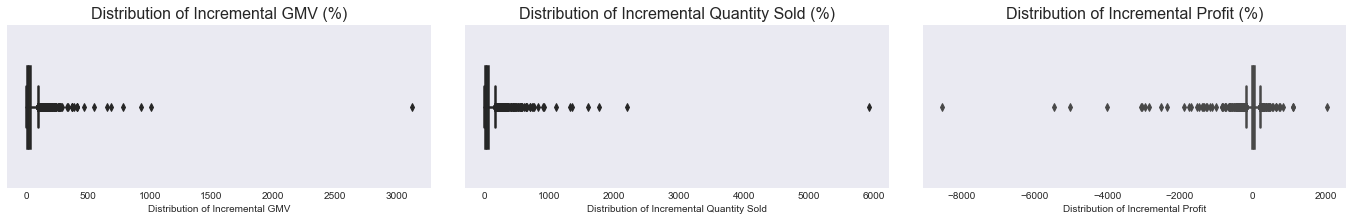

In [31]:
desc = df[['incremental_gmv_tab','incremental_quantity_tab','incremental_profit_ext_tab']].describe(percentiles=[0, 0.25, 0.5, 0.75, 1])
for col in desc.columns:
    desc[col] = np.round(desc[col], 2)
    
display(utils.display_df(desc))

fig, ax = plt.subplots(1,3, figsize = (24,3), sharey=False)
plt.subplots_adjust(wspace = 0.08)

# GMV
sns.boxplot(x = 'incremental_gmv_tab', data = df, ax = ax[0], color = 'olive', whis = 3, width = 0.5, linewidth = 2.5)
ax[0].set_title('Distribution of Incremental GMV (%)', fontsize = 16)
ax[0].set_xlabel('Distribution of Incremental GMV')

# Quantity Sold
sns.boxplot(x = 'incremental_quantity_tab', data = df, ax = ax[1], color = 'teal', whis = 3, width = 0.5, linewidth = 2.5)
ax[1].set_title('Distribution of Incremental Quantity Sold (%)', fontsize = 16)
ax[1].set_xlabel('Distribution of Incremental Quantity Sold')

# Quantity Sold
sns.boxplot(x = 'incremental_profit_ext_tab', data = df, ax = ax[2], color = 'crimson', whis = 3, width = 0.5, linewidth = 2.5)
ax[2].set_title('Distribution of Incremental Profit (%)', fontsize = 16)
ax[2].set_xlabel('Distribution of Incremental Profit')



In [32]:
# GMV
sns.histplot(x = 'incremental_gmv_tab', data = df, ax = ax[0], color = 'olive', kde = True)
ax[0].set_title('Distribution of Incremental GMV (%)', fontsize = 16)
ax[0].set_xlabel('Distribution of Incremental GMV')

# Quantity Sold
sns.histplot(x = 'incremental_quantity_tab', data = df, ax = ax[1], color = 'teal', kde = True)
ax[1].set_title('Distribution of Incremental Quantity Sold (%)', fontsize = 16)
ax[1].set_xlabel('Distribution of Incremental Quantity Sold')

# Quantity Sold
sns.histplot(x = 'incremental_profit_ext_tab', data = df, ax = ax[2], color = 'crimson', kde = True)
ax[2].set_title('Distribution of Incremental Profit (%)', fontsize = 16)
ax[2].set_xlabel('Distribution of Incremental Profit');

In [33]:
desc = df[['incremental_gmv_tab','incremental_quantity_tab','incremental_profit_ext_tab']].describe(percentiles=[0, 0.25, 0.5, 0.75, 1])
for col in desc.columns:
    desc[col] = np.round(desc[col], 2)
    
utils.display_df(desc)

,incremental_gmv_tab,incremental_quantity_tab,incremental_profit_ext_tab
count,10139.00,10139.00,10133.00
mean,24.13,50.51,-8.07
std,46.39,88.10,168.19
min,0.00,1.01,-8544.12
0%,0.00,1.01,-8544.12
25%,6.94,20.97,-25.04
50%,15.14,35.14,8.55
75%,28.75,58.73,30.23
100%,3122.47,5930.15,2044.93
max,3122.47,5930.15,2044.93


In [34]:
df.columns

Index(['order_date', 'global_entity_id', 'warehouse', 'supplier', 'sku',
       'no_of_campaigns', 'campaign_id', 'campaign_name',
       'campaign_created_time_utc', 'campaign_start_time_utc',
       'campaign_end_time_utc', 'is_campaign_active', 'category',
       'subcategory', 'brand', 'product', 'y_pred_base', 'y_pred', 'b_qty',
       'qty_sold', 'incremental_quantity_tab',
       'is_outlier_incremental_quantity', 'price_base', 'price', 'cost',
       'b_gmv', 'gmv', 'incremental_gmv_tab', 'is_outlier_incremental_gmv',
       'b_profit', 'profit', 'profit_ext', 'incremental_profit_ext_tab',
       'is_outlier_incremental_profit_ext', 'execution_date', 'confidence',
       'discount', 'externally_funded_percentage', 'number_of_campaign_days'],
      dtype='object')

## Numerical Distributions by global entity id

In [35]:
# Numerical Columns
numerical_columns = df._get_numeric_data().columns
print(numerical_columns)

Index(['no_of_campaigns', 'is_campaign_active', 'y_pred_base', 'y_pred',
       'b_qty', 'qty_sold', 'incremental_quantity_tab', 'price_base', 'price',
       'cost', 'b_gmv', 'gmv', 'incremental_gmv_tab', 'b_profit', 'profit',
       'profit_ext', 'incremental_profit_ext_tab', 'discount',
       'externally_funded_percentage', 'number_of_campaign_days'],
      dtype='object')


In [36]:
# Choose Columns
category_col = ['global_entity_id']
cols_of_interest = ['no_of_campaigns','y_pred_base', 'y_pred',
       'b_qty', 'qty_sold', 'incremental_quantity_tab', 'price_base', 'price',
       'cost', 'b_gmv', 'gmv', 'incremental_gmv_tab', 'b_profit', 'profit',
       'profit_ext', 'incremental_profit_ext_tab', 'discount',
       'externally_funded_percentage', 'number_of_campaign_days']
# Loop through Columns
for cols in cols_of_interest:
    display(df.groupby(category_col)[cols].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).sort_values(by=['mean'], ascending = False).rename_axis(cols)\
                                                                                                                    .style.format({"count": "{0:.0f}", 
                                                                                                                          "mean": "{0:.2f}", 
                                                                                                                          "std": "{0:.2f}",
                                                                                                                          "min":"{0:.2f}",
                                                                                                                           "1%": "{0:.2f}",
                                                                                                                           "5%": "{0:.2f}",
                                                                                                                          "10%": "{0:.2f}",
                                                                                                                          "25%": "{0:.2f}",
                                                                                                                          "50%": "{0:.2f}",
                                                                                                                          "75%": "{0:.2f}",
                                                                                                                          "90%": "{0:.2f}",
                                                                                                                          "95%": "{0:.2f}",
                                                                                                                         "95%": "{0:.2f}",
                                                                                                                         "99%": "{0:.2f}",
                                                                                                                          "max": "{0:.2f}"})\
                                                                                                                       .background_gradient(cmap='Blues'))

    

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
no_of_campaigns,,,,,,,,,,,,,,
HF_EG,221,2.51,5.61,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,24.00,24.00,24.00
FP_BD,586,2.10,1.36,1.00,1.00,1.00,1.00,1.00,2.00,3.00,4.00,5.00,7.00,7.00
FP_TW,1323,2.02,1.71,1.00,1.00,1.00,1.00,1.00,1.00,2.00,4.00,5.00,10.00,15.00
TB_BH,7,2.00,1.53,1.00,1.00,1.00,1.00,1.00,1.00,2.50,3.80,4.40,4.88,5.00
FP_SG,2183,1.83,0.92,1.00,1.00,1.00,1.00,1.00,2.00,2.00,3.00,3.00,5.00,8.00
FP_HK,1461,1.70,1.04,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00,4.00,6.00,9.00
TB_AE,492,1.69,0.92,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00,3.00,5.00,6.00
FP_TH,1181,1.68,0.91,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00,3.00,4.20,6.00
FP_PK,603,1.59,0.93,1.00,1.00,1.00,1.00,1.00,1.00,2.00,3.00,3.00,5.00,6.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
y_pred_base,,,,,,,,,,,,,,
TB_BH,7,6.67,5.82,1.36,1.37,1.40,1.43,3.38,5.77,7.06,11.85,15.28,18.02,18.70
FP_PK,603,6.16,10.50,0.27,0.79,1.14,1.28,1.74,2.84,5.49,13.82,22.71,54.13,118.64
TB_AE,492,4.89,5.54,0.79,0.91,1.06,1.28,1.76,2.82,5.60,11.47,16.01,27.65,45.80
FP_BD,586,4.33,7.29,0.29,0.49,0.81,0.99,1.36,2.27,4.47,8.43,14.23,29.81,123.00
FP_TH,1181,4.20,8.61,0.41,0.87,1.13,1.26,1.53,2.16,3.80,7.28,13.92,34.93,185.32
HF_EG,221,4.06,5.69,0.46,0.77,1.11,1.32,1.67,2.48,4.13,6.85,9.63,29.77,49.41
FP_SG,2183,4.05,4.46,0.41,0.88,1.18,1.36,1.71,2.56,4.58,8.53,11.26,22.44,54.31
HS_SA,667,3.59,3.25,0.70,0.95,1.26,1.47,1.82,2.61,4.13,6.39,9.00,17.94,28.81
FP_MY,1405,3.33,3.45,0.39,0.88,1.12,1.28,1.65,2.34,3.77,6.19,8.74,17.96,60.65


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
y_pred,,,,,,,,,,,,,,
TB_BH,7,17.54,24.78,2.39,2.39,2.40,2.41,4.68,8.02,15.34,39.55,55.94,69.05,72.33
FP_PK,603,8.49,16.08,0.92,1.28,1.54,1.79,2.32,3.87,7.50,18.12,31.04,70.17,246.00
TB_AE,492,7.73,9.45,1.06,1.32,1.70,1.91,2.68,4.23,8.48,18.16,24.40,47.87,86.74
HF_EG,221,7.44,16.16,1.04,1.21,1.61,1.88,2.57,3.83,5.91,11.26,15.51,93.39,165.99
FP_BD,586,7.34,13.81,0.56,1.04,1.38,1.60,2.22,3.58,6.84,13.42,28.07,59.07,222.13
FP_TH,1181,6.04,14.01,0.89,1.19,1.47,1.61,2.01,2.97,5.29,11.03,19.73,48.04,334.23
FP_SG,2183,5.78,6.43,0.94,1.20,1.55,1.79,2.33,3.49,6.54,12.13,17.67,32.26,77.66
HS_SA,667,5.20,5.06,1.06,1.24,1.61,1.88,2.38,3.65,6.11,9.37,13.63,29.17,40.75
FP_MY,1405,5.03,4.74,0.89,1.23,1.62,1.83,2.38,3.54,5.84,9.85,13.83,22.58,70.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
b_qty,,,,,,,,,,,,,,
TB_BH,7,11.66,17.96,1.14,1.22,1.53,1.93,3.12,6.96,7.65,25.69,38.83,49.33,51.96
FP_PK,603,6.44,15.27,0.22,0.41,0.64,0.73,1.35,2.48,5.92,13.67,24.81,72.06,253.55
TB_AE,492,4.75,6.09,0.25,0.42,0.57,0.71,1.15,2.66,5.65,11.96,16.97,28.16,50.51
FP_BD,586,4.20,7.06,0.15,0.33,0.50,0.63,0.87,1.89,4.25,9.64,15.42,32.09,68.49
FP_TH,1181,4.14,8.80,0.27,0.54,0.70,0.76,0.90,1.95,3.64,8.26,13.54,39.89,140.70
FP_SG,2183,4.11,5.56,0.23,0.53,0.70,0.76,1.11,2.28,4.69,9.76,13.71,25.90,75.95
HF_EG,221,4.03,6.06,0.34,0.50,0.62,0.65,0.85,2.07,4.31,9.36,12.82,32.17,48.54
HS_SA,667,3.71,4.52,0.29,0.48,0.69,0.77,1.17,2.21,4.40,8.44,11.47,23.23,51.10
FP_TW,1323,3.46,3.93,0.27,0.47,0.64,0.75,1.16,2.37,4.29,7.34,10.47,17.65,55.23


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
qty_sold,,,,,,,,,,,,,,
TB_BH,7,36.43,72.82,2.00,2.12,2.60,3.20,4.50,9.00,17.00,91.20,146.10,190.02,201.00
FP_PK,603,8.98,23.35,1.00,1.00,1.00,1.00,2.00,3.00,8.00,18.00,31.00,96.90,360.00
TB_AE,492,7.58,12.83,1.00,1.00,1.00,1.00,2.00,4.00,9.00,18.90,24.45,43.81,203.00
HF_EG,221,7.52,20.44,1.00,1.00,1.00,1.00,1.00,3.00,7.00,14.00,21.00,68.40,265.00
FP_BD,586,6.96,12.34,1.00,1.00,1.00,1.00,1.00,3.00,6.00,15.50,28.50,69.30,115.00
FP_TH,1181,5.95,13.58,1.00,1.00,1.00,1.00,1.00,3.00,5.00,12.00,19.00,62.80,187.00
FP_SG,2183,5.90,8.14,1.00,1.00,1.00,1.00,2.00,3.00,7.00,14.00,20.00,40.00,106.00
HS_SA,667,5.38,6.83,1.00,1.00,1.00,1.00,2.00,3.00,6.00,12.00,17.70,34.34,68.00
FP_TW,1323,5.02,5.49,1.00,1.00,1.00,1.00,2.00,3.00,6.00,11.00,15.00,26.00,66.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_quantity_tab,,,,,,,,,,,,,,
TB_BH,7,107.21,94.27,10.02,11.32,16.49,22.96,47.42,75.44,141.67,209.91,248.37,279.14,286.84
FP_BD,586,75.98,117.36,1.01,4.88,8.74,12.36,21.95,43.61,90.23,163.74,223.45,566.67,1598.11
PO_FI,10,67.52,33.98,14.94,18.36,32.03,49.11,53.04,54.74,71.97,124.80,125.18,125.49,125.56
TB_AE,492,63.62,83.77,2.95,10.34,14.32,19.05,29.87,47.06,76.76,107.80,139.85,300.39,1352.51
HF_EG,221,59.50,54.68,4.71,6.38,15.91,19.70,29.03,47.60,68.54,101.34,156.41,226.52,446.45
FP_MY,1405,57.50,66.44,1.74,7.53,12.42,15.97,26.58,42.18,64.25,99.73,148.00,354.27,769.57
FP_PK,603,54.28,251.34,1.01,3.09,5.63,8.75,13.85,27.48,48.94,86.28,136.74,334.41,5930.15
FP_TW,1323,53.17,94.71,2.04,5.56,9.49,12.11,20.48,36.99,62.16,101.34,127.83,250.88,2198.14
FP_HK,1461,46.37,42.68,2.04,6.38,11.11,13.64,19.90,33.33,58.26,91.08,123.46,201.08,471.43


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
price_base,,,,,,,,,,,,,,
FP_PK,603,161.19,172.11,8.00,15.00,25.00,35.00,60.00,120.00,185.00,320.00,469.20,930.00,1428.13
FP_BD,586,134.20,178.26,8.00,10.00,17.00,20.50,35.00,60.00,153.00,350.00,450.00,760.00,1230.00
FP_TW,1323,79.77,60.88,10.00,15.00,20.00,25.00,35.00,64.00,109.00,149.80,189.00,299.00,499.00
FP_TH,1181,42.39,32.54,10.00,10.00,15.00,18.00,22.00,30.00,55.00,79.00,105.00,171.20,287.00
FP_HK,1461,23.53,20.43,3.90,4.06,6.00,7.80,10.90,15.90,26.90,49.90,69.90,109.90,124.90
HF_EG,221,14.65,17.68,1.95,1.95,2.75,3.95,5.25,10.45,15.75,23.50,58.50,92.95,92.95
TB_AE,492,13.11,8.30,1.00,1.35,2.57,3.50,6.35,10.75,19.00,22.50,28.97,35.40,50.14
HS_SA,667,9.98,7.86,1.00,1.10,1.25,1.55,3.95,7.45,13.95,23.65,25.98,28.95,39.95
FP_SG,2183,7.81,9.97,0.55,1.00,1.30,1.40,2.05,4.30,10.90,16.90,28.25,55.00,88.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
price,,,,,,,,,,,,,,
FP_PK,603,140.71,156.63,7.56,12.02,20.12,28.86,52.00,102.00,156.75,289.00,352.50,875.00,1213.91
FP_BD,586,119.54,164.41,4.00,8.90,14.36,18.30,30.00,50.67,139.70,306.00,428.99,719.98,1174.59
FP_TW,1323,66.38,48.24,5.00,10.00,17.00,22.00,29.00,54.00,86.62,138.20,168.00,235.00,399.00
FP_TH,1181,37.24,28.23,6.00,9.00,13.00,15.00,19.50,26.00,48.00,74.00,99.00,147.00,249.00
FP_HK,1461,20.13,17.65,1.00,3.50,4.90,6.00,9.40,14.00,24.21,38.63,55.00,99.90,112.41
HF_EG,221,12.18,14.84,1.44,1.65,1.94,2.95,4.45,8.71,13.59,18.94,48.94,80.05,81.94
TB_AE,492,9.83,6.38,0.77,1.01,1.82,2.70,4.80,8.49,14.99,15.67,23.59,26.95,38.99
HS_SA,667,8.30,6.84,0.62,0.66,0.97,1.34,3.01,6.16,11.02,20.34,22.36,25.95,33.95
FP_SG,2183,6.76,8.69,0.45,0.79,1.05,1.26,1.83,3.66,9.30,15.19,21.89,49.50,68.95


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
cost,,,,,,,,,,,,,,
FP_PK,603,119.14,137.42,3.50,9.45,16.67,26.60,39.36,80.77,140.00,229.34,347.52,775.08,1132.33
FP_BD,586,114.70,153.16,6.80,8.04,12.15,17.66,28.91,50.35,134.75,301.00,402.92,687.87,1091.91
FP_TW,1323,51.83,39.88,5.62,7.14,12.38,15.90,22.62,44.76,65.94,104.00,128.57,191.00,300.00
FP_TH,1181,33.83,25.99,2.75,7.79,11.95,13.22,18.39,23.97,44.21,66.64,87.48,137.07,231.56
FP_HK,1461,16.60,15.94,2.30,2.73,3.86,5.00,7.35,11.18,19.25,31.70,41.81,96.00,101.10
HF_EG,221,11.83,15.04,1.49,1.55,1.89,2.98,4.15,8.46,12.89,16.64,46.06,86.18,87.69
TB_AE,492,9.01,5.99,0.65,0.90,1.65,2.39,4.35,7.50,14.29,16.50,20.10,27.55,33.25
HS_SA,667,6.81,5.48,0.69,0.71,0.82,1.02,2.58,5.00,9.61,17.00,17.14,21.00,27.81
FP_SG,2183,6.13,8.07,0.31,0.70,0.95,1.07,1.67,3.14,8.10,14.72,22.36,42.66,63.29


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
b_gmv,,,,,,,,,,,,,,
FP_PK,603,636.25,1174.90,10.31,30.84,59.66,81.45,141.11,290.63,614.36,1238.77,2301.04,6222.03,16615.01
FP_BD,586,431.11,927.13,2.19,9.89,19.98,28.82,59.57,151.15,412.16,937.90,1595.95,4636.98,10061.88
FP_TW,1323,257.90,393.10,7.68,14.28,25.45,38.81,71.00,141.84,290.91,532.69,851.17,2063.09,4916.21
FP_TH,1181,177.16,469.71,6.58,8.59,14.46,19.27,33.91,67.46,145.83,370.76,642.27,1605.10,8442.16
FP_HK,1461,67.82,89.15,3.20,4.39,7.42,10.73,18.60,39.60,80.67,151.35,218.21,487.00,974.71
TB_AE,492,51.07,65.03,0.78,2.07,3.40,5.39,12.68,28.15,61.35,119.30,178.35,272.71,600.31
HF_EG,221,41.18,66.12,1.57,2.53,3.86,5.55,10.30,21.34,48.22,97.34,132.12,225.74,778.72
HS_SA,667,30.90,48.56,0.66,1.21,3.05,4.18,7.58,17.15,35.81,64.92,106.11,202.00,587.73
FP_SG,2183,26.18,49.38,0.43,0.92,1.52,2.35,4.75,11.04,26.92,60.61,95.85,243.36,695.77


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
gmv,,,,,,,,,,,,,,
FP_PK,603,759.89,1385.55,12.75,40.02,66.07,96.40,173.00,354.00,770.00,1686.00,2757.80,6722.65,17550.00
FP_BD,586,590.89,1316.59,7.99,14.70,30.00,39.00,85.00,210.00,560.88,1239.75,2087.54,7092.95,13728.00
FP_TW,1323,310.41,463.65,8.00,19.00,31.00,46.00,85.00,169.98,360.00,657.00,1062.91,2264.24,6728.16
FP_TH,1181,227.97,643.16,7.00,10.84,17.00,22.00,39.15,80.00,175.00,441.00,810.00,2218.80,10098.00
FP_HK,1461,84.92,114.02,3.50,4.90,8.62,12.50,22.00,47.60,104.00,188.30,281.70,557.82,1398.60
TB_AE,492,58.63,73.12,0.94,2.23,4.02,6.64,15.00,33.52,70.58,139.95,206.80,314.34,659.96
HF_EG,221,55.74,105.51,1.74,3.32,4.88,7.90,11.85,26.61,61.71,122.50,165.20,366.26,1303.20
HS_SA,667,35.29,55.35,0.71,1.37,3.31,4.76,8.71,19.32,39.03,79.80,129.84,246.41,620.62
FP_SG,2183,32.84,67.62,0.70,1.15,1.70,2.80,5.56,12.95,31.96,75.68,119.40,321.92,1010.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_gmv_tab,,,,,,,,,,,,,,
FP_BD,586,46.69,79.09,0.00,0.17,1.63,3.37,10.02,25.18,58.27,103.34,154.93,286.78,1010.74
TB_BH,7,41.35,37.58,1.81,2.28,4.16,6.51,19.88,30.88,55.34,89.51,97.91,104.63,106.31
PO_FI,10,31.34,21.31,0.52,0.77,1.81,3.11,16.55,35.86,39.20,56.90,61.63,65.41,66.35
HF_EG,221,29.03,29.92,0.00,0.96,2.27,4.22,8.75,19.83,39.11,60.24,94.56,135.79,166.50
FP_MY,1405,26.35,31.87,0.00,0.39,1.80,3.57,8.71,18.21,33.77,54.59,73.71,149.36,370.59
FP_PK,603,26.26,130.94,0.01,0.03,0.71,1.75,4.80,11.27,22.30,47.83,69.71,155.26,3122.47
FP_TW,1323,24.70,44.15,0.00,0.16,0.81,1.63,5.37,14.36,26.80,55.21,82.57,151.65,778.64
FP_HK,1461,23.51,25.15,0.00,0.20,1.55,2.99,7.07,15.46,32.28,53.94,67.95,116.52,252.95
FP_TH,1181,22.10,20.89,0.10,0.33,2.48,4.53,8.98,16.79,28.42,44.09,56.69,105.45,173.89


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
b_profit,,,,,,,,,,,,,,
FP_PK,603,129.47,183.69,-1304.29,4.07,10.83,18.48,32.52,69.21,168.90,323.40,455.07,796.93,1718.41
FP_TW,1323,81.99,106.27,1.89,4.28,8.59,12.03,23.08,46.68,98.62,188.61,275.96,551.12,963.72
FP_BD,586,51.17,111.04,-866.18,-58.96,1.82,3.55,8.06,22.27,57.80,122.92,183.95,543.02,971.05
FP_TH,1181,34.62,95.65,1.27,1.85,2.32,3.33,6.27,12.25,27.59,68.83,128.52,319.59,1716.57
FP_HK,1461,19.38,24.33,0.80,1.30,2.11,2.68,5.08,11.44,22.96,44.07,64.19,130.79,241.41
TB_AE,492,16.34,22.16,-5.04,0.24,0.96,1.59,3.54,8.75,18.63,41.52,64.48,102.78,158.98
HS_SA,667,9.86,15.02,0.19,0.40,0.97,1.34,2.41,5.31,11.32,21.65,32.58,64.86,170.88
HF_EG,221,8.58,14.64,-0.83,0.23,0.50,0.88,1.65,3.74,8.40,20.65,33.76,79.94,114.46
FP_SG,2183,5.06,7.54,0.09,0.21,0.35,0.51,1.12,2.55,5.92,11.69,18.20,37.08,111.29


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
profit,,,,,,,,,,,,,,
FP_PK,603,71.28,284.52,-5277.32,-523.46,-33.40,-2.77,15.91,44.64,119.40,239.68,362.48,613.78,1359.84
FP_TW,1323,59.33,114.51,-2327.30,-21.49,1.01,5.94,15.00,33.62,76.10,154.52,224.68,443.05,727.98
FP_TH,1181,17.81,61.73,-737.31,-42.07,-4.84,-0.92,1.74,6.24,18.27,44.20,80.55,241.02,1159.40
FP_HK,1461,14.57,21.49,-42.30,-4.03,0.00,1.20,3.02,7.20,17.50,36.00,52.29,102.18,249.60
HS_SA,667,5.69,14.46,-85.05,-26.45,-2.72,-0.21,0.85,2.67,7.36,15.92,25.37,53.79,160.65
TB_AE,492,5.69,19.79,-200.97,-39.10,-12.40,-5.10,0.46,2.76,7.81,20.86,36.11,77.51,126.00
PO_FI,10,2.39,3.14,-0.52,-0.46,-0.20,0.13,1.22,1.58,2.36,3.89,7.34,10.11,10.80
FP_SG,2183,2.20,8.38,-166.60,-13.58,-2.00,-0.46,0.32,1.14,3.24,7.04,11.30,24.11,138.06
HF_EG,221,2.02,13.98,-129.85,-18.89,-6.30,-3.84,-0.55,0.48,2.76,9.84,18.27,50.90,90.21


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
profit_ext,,,,,,,,,,,,,,
FP_PK,603,91.94,291.18,-5277.32,-324.93,-12.12,2.53,20.40,55.53,137.45,285.10,407.41,962.25,1359.84
FP_TW,1323,59.33,114.51,-2327.30,-21.49,1.01,5.94,15.00,33.62,76.10,154.52,224.68,443.05,727.98
FP_TH,1181,48.50,155.83,-502.81,-1.98,2.90,3.92,7.62,15.16,33.96,86.00,183.00,549.00,2281.40
FP_BD,586,26.31,188.11,-2436.00,-471.45,-83.56,-24.27,1.50,12.80,52.66,120.75,199.42,585.99,1722.50
FP_HK,1461,24.54,35.96,-42.30,-0.31,2.20,3.18,5.98,12.84,27.90,56.60,79.50,184.52,396.90
HS_SA,667,12.29,20.39,-34.32,-4.34,0.48,1.22,2.63,6.52,14.02,29.86,49.80,96.47,214.65
TB_BH,7,10.80,22.43,0.18,0.21,0.31,0.43,0.68,0.97,5.86,28.22,44.79,58.05,61.36
TB_AE,492,7.17,20.26,-200.97,-31.78,-8.45,-1.83,0.81,3.53,10.11,23.51,42.25,79.01,126.00
FP_SG,2183,5.18,11.04,-166.60,-3.21,-0.06,0.32,0.95,2.45,6.32,12.79,20.20,44.55,162.35


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_profit_ext_tab,,,,,,,,,,,,,,
TB_BH,7,107.46,93.90,12.50,13.64,18.22,23.95,46.62,76.47,141.56,209.69,248.29,279.17,286.89
FP_TH,1181,28.36,66.02,-1544.03,-112.13,-9.22,5.28,15.08,25.48,41.33,65.79,95.36,197.91,261.29
FP_HK,1461,25.52,62.03,-1250.00,-109.30,-51.79,-22.26,9.75,24.36,44.85,79.32,102.78,182.74,412.17
HS_SA,667,23.32,71.14,-327.59,-213.84,-49.72,-30.85,7.74,23.17,38.40,70.88,99.42,276.69,757.12
FP_SG,2183,3.33,65.92,-625.88,-240.06,-108.13,-56.14,-15.25,13.20,30.69,55.36,77.74,141.94,648.94
FP_MY,1405,-2.97,74.20,-356.44,-241.03,-151.57,-100.00,-19.57,9.52,29.67,51.81,69.03,199.82,635.09
FP_TW,1323,-30.51,146.50,-4004.21,-261.62,-98.96,-68.75,-39.13,-16.95,-5.30,10.51,29.24,73.13,315.87
PO_FI,10,-32.85,54.63,-161.90,-155.26,-128.66,-95.41,-46.23,-8.23,-1.89,4.60,6.20,7.47,7.79
FP_PK,603,-41.77,249.46,-5031.15,-485.53,-137.40,-85.59,-36.47,-15.11,-1.17,17.55,37.74,94.82,556.79


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
discount,,,,,,,,,,,,,,
TB_BH,7,26.71,15.90,7.00,7.60,10.00,13.00,18.50,21.00,36.00,48.20,49.10,49.82,50.00
TB_AE,492,24.33,11.78,2.00,5.00,8.00,11.00,17.00,22.00,30.00,39.80,50.00,65.18,82.00
PO_FI,10,20.10,12.30,10.00,10.00,10.00,10.00,10.00,15.00,25.75,40.00,40.00,40.00,40.00
HS_SA,667,18.22,11.30,1.00,1.66,5.00,7.00,10.00,15.00,20.00,35.00,50.00,50.00,57.00
HF_EG,221,17.22,8.51,1.00,3.00,6.00,8.00,11.00,17.00,21.00,28.00,32.00,40.00,51.00
FP_MY,1405,17.16,8.80,1.00,5.00,5.00,9.00,10.00,15.00,23.00,26.00,30.00,50.00,80.00
FP_TW,1323,15.66,11.12,1.00,2.00,4.00,5.00,8.00,12.00,20.00,33.00,40.00,50.00,72.00
FP_HK,1461,14.02,8.55,1.00,3.00,4.00,5.00,9.00,11.00,17.00,25.00,32.00,41.40,76.00
FP_SG,2183,13.35,7.54,1.00,3.00,5.00,5.00,8.00,11.00,18.00,22.00,26.90,40.00,66.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
externally_funded_percentage,,,,,,,,,,,,,,
TB_BH,7,100.00,0.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_TH,1181,88.98,27.47,0.00,0.00,0.00,77.33,97.00,100.00,100.00,100.00,100.00,100.00,100.00
HS_SA,667,78.53,39.01,0.00,0.00,0.00,0.00,75.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_HK,1461,75.00,43.15,0.00,0.00,0.00,0.00,56.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_SG,2183,61.96,41.95,0.00,0.00,0.00,0.00,0.00,80.00,100.00,100.00,100.00,100.00,100.00
FP_MY,1405,60.18,32.75,0.00,0.00,0.00,0.00,46.75,79.00,80.00,86.80,100.00,100.00,100.00
FP_BD,586,35.60,46.96,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00,100.00,100.00,100.00
FP_PK,603,16.89,27.60,0.00,0.00,0.00,0.00,0.00,0.00,50.00,50.00,50.00,100.00,100.00
TB_AE,492,12.92,28.55,0.00,0.00,0.00,0.00,0.00,0.00,0.00,68.80,100.00,100.00,100.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
number_of_campaign_days,,,,,,,,,,,,,,
FP_TW,1323,365.87,2945.22,0.00,0.00,0.00,1.00,3.00,14.00,103.00,247.00,247.00,22562.44,28821.00
TB_AE,492,39.06,68.57,0.00,0.00,1.00,2.00,6.00,10.00,27.00,211.00,220.00,248.00,274.00
TB_BH,7,35.86,64.24,2.00,2.24,3.20,4.40,10.50,15.00,16.00,82.00,131.50,171.10,181.00
FP_BD,586,22.16,13.60,0.00,0.00,2.00,5.00,10.25,24.00,30.00,31.00,44.00,60.80,80.00
FP_HK,1461,16.51,11.18,0.00,0.00,1.00,5.00,8.00,15.00,26.00,31.00,31.00,59.00,74.00
FP_SG,2183,16.45,15.79,0.00,1.00,3.00,5.00,7.00,7.00,28.00,31.00,34.90,85.00,122.00
FP_PK,603,16.39,18.61,0.00,0.00,1.00,2.00,4.00,11.00,20.00,34.00,61.00,124.92,126.00
FP_TH,1181,13.06,10.66,0.00,0.80,2.00,4.00,7.00,9.00,16.00,29.00,31.00,51.00,80.00
HF_EG,221,12.07,5.33,0.00,0.00,0.00,5.00,10.00,13.00,14.00,21.00,21.00,21.00,21.00


#### Boxplots on a country level

In [37]:
# Choose Columns
category_col = ['global_entity_id']
cols_of_interest = ['discount', 'externally_funded_percentage','number_of_campaign_days']
# Loop through Columns
for cols in cols_of_interest:
    display(df.groupby(category_col)[cols].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).sort_values(by=['mean'], ascending = False).rename_axis(cols)\
                                                                                                                    .style.format({"count": "{0:.0f}", 
                                                                                                                          "mean": "{0:.2f}", 
                                                                                                                          "std": "{0:.2f}",
                                                                                                                          "min":"{0:.2f}",
                                                                                                                           "1%": "{0:.2f}",
                                                                                                                           "5%": "{0:.2f}",
                                                                                                                          "10%": "{0:.2f}",
                                                                                                                          "25%": "{0:.2f}",
                                                                                                                          "50%": "{0:.2f}",
                                                                                                                          "75%": "{0:.2f}",
                                                                                                                          "90%": "{0:.2f}",
                                                                                                                          "95%": "{0:.2f}",
                                                                                                                         "95%": "{0:.2f}",
                                                                                                                         "99%": "{0:.2f}",
                                                                                                                          "max": "{0:.2f}"})\
                                                                                                                       .background_gradient(cmap='Blues'))

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
discount,,,,,,,,,,,,,,
TB_BH,7,26.71,15.90,7.00,7.60,10.00,13.00,18.50,21.00,36.00,48.20,49.10,49.82,50.00
TB_AE,492,24.33,11.78,2.00,5.00,8.00,11.00,17.00,22.00,30.00,39.80,50.00,65.18,82.00
PO_FI,10,20.10,12.30,10.00,10.00,10.00,10.00,10.00,15.00,25.75,40.00,40.00,40.00,40.00
HS_SA,667,18.22,11.30,1.00,1.66,5.00,7.00,10.00,15.00,20.00,35.00,50.00,50.00,57.00
HF_EG,221,17.22,8.51,1.00,3.00,6.00,8.00,11.00,17.00,21.00,28.00,32.00,40.00,51.00
FP_MY,1405,17.16,8.80,1.00,5.00,5.00,9.00,10.00,15.00,23.00,26.00,30.00,50.00,80.00
FP_TW,1323,15.66,11.12,1.00,2.00,4.00,5.00,8.00,12.00,20.00,33.00,40.00,50.00,72.00
FP_HK,1461,14.02,8.55,1.00,3.00,4.00,5.00,9.00,11.00,17.00,25.00,32.00,41.40,76.00
FP_SG,2183,13.35,7.54,1.00,3.00,5.00,5.00,8.00,11.00,18.00,22.00,26.90,40.00,66.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
externally_funded_percentage,,,,,,,,,,,,,,
TB_BH,7,100.00,0.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_TH,1181,88.98,27.47,0.00,0.00,0.00,77.33,97.00,100.00,100.00,100.00,100.00,100.00,100.00
HS_SA,667,78.53,39.01,0.00,0.00,0.00,0.00,75.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_HK,1461,75.00,43.15,0.00,0.00,0.00,0.00,56.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_SG,2183,61.96,41.95,0.00,0.00,0.00,0.00,0.00,80.00,100.00,100.00,100.00,100.00,100.00
FP_MY,1405,60.18,32.75,0.00,0.00,0.00,0.00,46.75,79.00,80.00,86.80,100.00,100.00,100.00
FP_BD,586,35.60,46.96,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00,100.00,100.00,100.00
FP_PK,603,16.89,27.60,0.00,0.00,0.00,0.00,0.00,0.00,50.00,50.00,50.00,100.00,100.00
TB_AE,492,12.92,28.55,0.00,0.00,0.00,0.00,0.00,0.00,0.00,68.80,100.00,100.00,100.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
number_of_campaign_days,,,,,,,,,,,,,,
FP_TW,1323,365.87,2945.22,0.00,0.00,0.00,1.00,3.00,14.00,103.00,247.00,247.00,22562.44,28821.00
TB_AE,492,39.06,68.57,0.00,0.00,1.00,2.00,6.00,10.00,27.00,211.00,220.00,248.00,274.00
TB_BH,7,35.86,64.24,2.00,2.24,3.20,4.40,10.50,15.00,16.00,82.00,131.50,171.10,181.00
FP_BD,586,22.16,13.60,0.00,0.00,2.00,5.00,10.25,24.00,30.00,31.00,44.00,60.80,80.00
FP_HK,1461,16.51,11.18,0.00,0.00,1.00,5.00,8.00,15.00,26.00,31.00,31.00,59.00,74.00
FP_SG,2183,16.45,15.79,0.00,1.00,3.00,5.00,7.00,7.00,28.00,31.00,34.90,85.00,122.00
FP_PK,603,16.39,18.61,0.00,0.00,1.00,2.00,4.00,11.00,20.00,34.00,61.00,124.92,126.00
FP_TH,1181,13.06,10.66,0.00,0.80,2.00,4.00,7.00,9.00,16.00,29.00,31.00,51.00,80.00
HF_EG,221,12.07,5.33,0.00,0.00,0.00,5.00,10.00,13.00,14.00,21.00,21.00,21.00,21.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_quantity_tab,,,,,,,,,,,,,,
TB_BH,7,107.21,94.27,10.02,11.32,16.49,22.96,47.42,75.44,141.67,209.91,248.37,279.14,286.84
FP_BD,586,75.98,117.36,1.01,4.88,8.74,12.36,21.95,43.61,90.23,163.74,223.45,566.67,1598.11
PO_FI,10,67.52,33.98,14.94,18.36,32.03,49.11,53.04,54.74,71.97,124.80,125.18,125.49,125.56
TB_AE,492,63.62,83.77,2.95,10.34,14.32,19.05,29.87,47.06,76.76,107.80,139.85,300.39,1352.51
HF_EG,221,59.50,54.68,4.71,6.38,15.91,19.70,29.03,47.60,68.54,101.34,156.41,226.52,446.45
FP_MY,1405,57.50,66.44,1.74,7.53,12.42,15.97,26.58,42.18,64.25,99.73,148.00,354.27,769.57
FP_PK,603,54.28,251.34,1.01,3.09,5.63,8.75,13.85,27.48,48.94,86.28,136.74,334.41,5930.15
FP_TW,1323,53.17,94.71,2.04,5.56,9.49,12.11,20.48,36.99,62.16,101.34,127.83,250.88,2198.14
FP_HK,1461,46.37,42.68,2.04,6.38,11.11,13.64,19.90,33.33,58.26,91.08,123.46,201.08,471.43


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_gmv_tab,,,,,,,,,,,,,,
FP_BD,586,46.69,79.09,0.00,0.17,1.63,3.37,10.02,25.18,58.27,103.34,154.93,286.78,1010.74
TB_BH,7,41.35,37.58,1.81,2.28,4.16,6.51,19.88,30.88,55.34,89.51,97.91,104.63,106.31
PO_FI,10,31.34,21.31,0.52,0.77,1.81,3.11,16.55,35.86,39.20,56.90,61.63,65.41,66.35
HF_EG,221,29.03,29.92,0.00,0.96,2.27,4.22,8.75,19.83,39.11,60.24,94.56,135.79,166.50
FP_MY,1405,26.35,31.87,0.00,0.39,1.80,3.57,8.71,18.21,33.77,54.59,73.71,149.36,370.59
FP_PK,603,26.26,130.94,0.01,0.03,0.71,1.75,4.80,11.27,22.30,47.83,69.71,155.26,3122.47
FP_TW,1323,24.70,44.15,0.00,0.16,0.81,1.63,5.37,14.36,26.80,55.21,82.57,151.65,778.64
FP_HK,1461,23.51,25.15,0.00,0.20,1.55,2.99,7.07,15.46,32.28,53.94,67.95,116.52,252.95
FP_TH,1181,22.10,20.89,0.10,0.33,2.48,4.53,8.98,16.79,28.42,44.09,56.69,105.45,173.89


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
incremental_profit_ext_tab,,,,,,,,,,,,,,
TB_BH,7,107.46,93.90,12.50,13.64,18.22,23.95,46.62,76.47,141.56,209.69,248.29,279.17,286.89
FP_TH,1181,28.36,66.02,-1544.03,-112.13,-9.22,5.28,15.08,25.48,41.33,65.79,95.36,197.91,261.29
FP_HK,1461,25.52,62.03,-1250.00,-109.30,-51.79,-22.26,9.75,24.36,44.85,79.32,102.78,182.74,412.17
HS_SA,667,23.32,71.14,-327.59,-213.84,-49.72,-30.85,7.74,23.17,38.40,70.88,99.42,276.69,757.12
FP_SG,2183,3.33,65.92,-625.88,-240.06,-108.13,-56.14,-15.25,13.20,30.69,55.36,77.74,141.94,648.94
FP_MY,1405,-2.97,74.20,-356.44,-241.03,-151.57,-100.00,-19.57,9.52,29.67,51.81,69.03,199.82,635.09
FP_TW,1323,-30.51,146.50,-4004.21,-261.62,-98.96,-68.75,-39.13,-16.95,-5.30,10.51,29.24,73.13,315.87
PO_FI,10,-32.85,54.63,-161.90,-155.26,-128.66,-95.41,-46.23,-8.23,-1.89,4.60,6.20,7.47,7.79
FP_PK,603,-41.77,249.46,-5031.15,-485.53,-137.40,-85.59,-36.47,-15.11,-1.17,17.55,37.74,94.82,556.79


Text(0.5, 0, 'Distribution of Incremental Profit')

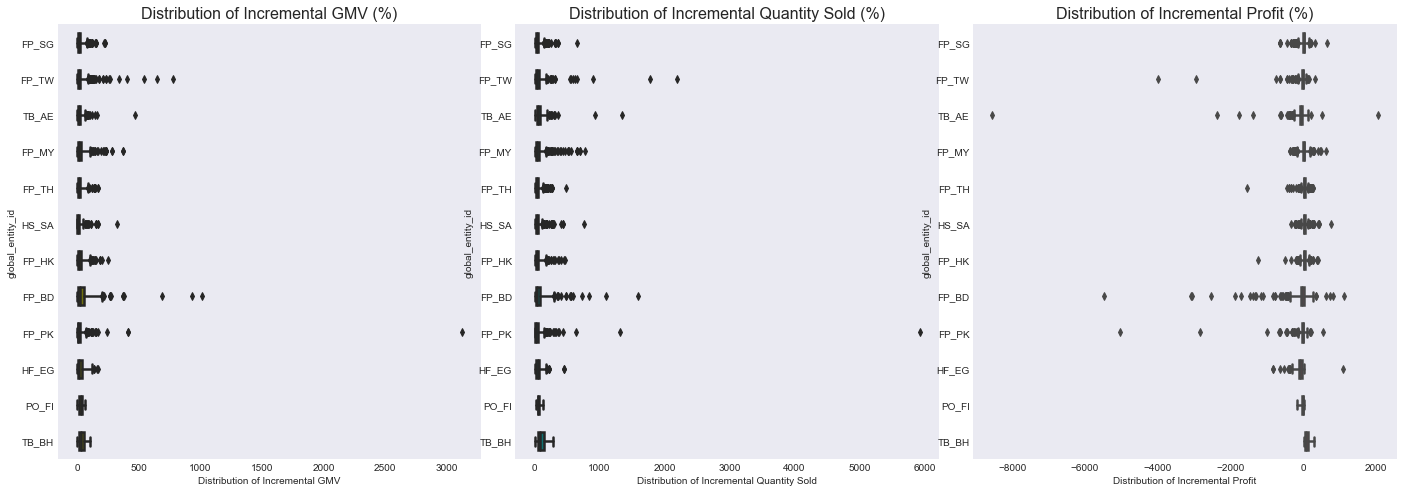

In [38]:
# Choose Columns
category_col = ['global_entity_id']
cols_of_interest = ['incremental_quantity_tab', 'incremental_gmv_tab','incremental_profit_ext_tab']
# Loop through Columns
for cols in cols_of_interest:
    display(df.groupby(category_col)[cols].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).sort_values(by=['mean'], ascending = False).rename_axis(cols)\
                                                                                                                    .style.format({"count": "{0:.0f}", 
                                                                                                                          "mean": "{0:.2f}", 
                                                                                                                          "std": "{0:.2f}",
                                                                                                                          "min":"{0:.2f}",
                                                                                                                           "1%": "{0:.2f}",
                                                                                                                           "5%": "{0:.2f}",
                                                                                                                          "10%": "{0:.2f}",
                                                                                                                          "25%": "{0:.2f}",
                                                                                                                          "50%": "{0:.2f}",
                                                                                                                          "75%": "{0:.2f}",
                                                                                                                          "90%": "{0:.2f}",
                                                                                                                          "95%": "{0:.2f}",
                                                                                                                         "95%": "{0:.2f}",
                                                                                                                         "99%": "{0:.2f}",
                                                                                                                          "max": "{0:.2f}"})\
                                                                                                                       .background_gradient(cmap='BuPu'))

fig, ax = plt.subplots(1,3, figsize = (24,8), sharey=False)
plt.subplots_adjust(wspace = 0.08)

# GMV
sns.boxplot(x = 'incremental_gmv_tab', y= 'global_entity_id', data = df, ax = ax[0], color = 'olive', whis = 3, width = 0.5, linewidth = 2.5)
ax[0].set_title('Distribution of Incremental GMV (%)', fontsize = 16)
ax[0].set_xlabel('Distribution of Incremental GMV')

# Quantity Sold
sns.boxplot(x = 'incremental_quantity_tab', y= 'global_entity_id', data = df, ax = ax[1], color = 'teal', whis = 3, width = 0.5, linewidth = 2.5)
ax[1].set_title('Distribution of Incremental Quantity Sold (%)', fontsize = 16)
ax[1].set_xlabel('Distribution of Incremental Quantity Sold')

# Quantity Sold
sns.boxplot(x = 'incremental_profit_ext_tab',y= 'global_entity_id', data = df, ax = ax[2], color = 'crimson', whis = 3, width = 0.5, linewidth = 2.5)
ax[2].set_title('Distribution of Incremental Profit (%)', fontsize = 16)
ax[2].set_xlabel('Distribution of Incremental Profit')

,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
discount,,,,,,,,,,,,,,
TB_BH,7,26.71,15.90,7.00,7.60,10.00,13.00,18.50,21.00,36.00,48.20,49.10,49.82,50.00
TB_AE,492,24.33,11.78,2.00,5.00,8.00,11.00,17.00,22.00,30.00,39.80,50.00,65.18,82.00
PO_FI,10,20.10,12.30,10.00,10.00,10.00,10.00,10.00,15.00,25.75,40.00,40.00,40.00,40.00
HS_SA,667,18.22,11.30,1.00,1.66,5.00,7.00,10.00,15.00,20.00,35.00,50.00,50.00,57.00
HF_EG,221,17.22,8.51,1.00,3.00,6.00,8.00,11.00,17.00,21.00,28.00,32.00,40.00,51.00
FP_MY,1405,17.16,8.80,1.00,5.00,5.00,9.00,10.00,15.00,23.00,26.00,30.00,50.00,80.00
FP_TW,1323,15.66,11.12,1.00,2.00,4.00,5.00,8.00,12.00,20.00,33.00,40.00,50.00,72.00
FP_HK,1461,14.02,8.55,1.00,3.00,4.00,5.00,9.00,11.00,17.00,25.00,32.00,41.40,76.00
FP_SG,2183,13.35,7.54,1.00,3.00,5.00,5.00,8.00,11.00,18.00,22.00,26.90,40.00,66.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
externally_funded_percentage,,,,,,,,,,,,,,
TB_BH,7,100.00,0.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_TH,1181,88.98,27.47,0.00,0.00,0.00,77.33,97.00,100.00,100.00,100.00,100.00,100.00,100.00
HS_SA,667,78.53,39.01,0.00,0.00,0.00,0.00,75.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_HK,1461,75.00,43.15,0.00,0.00,0.00,0.00,56.00,100.00,100.00,100.00,100.00,100.00,100.00
FP_SG,2183,61.96,41.95,0.00,0.00,0.00,0.00,0.00,80.00,100.00,100.00,100.00,100.00,100.00
FP_MY,1405,60.18,32.75,0.00,0.00,0.00,0.00,46.75,79.00,80.00,86.80,100.00,100.00,100.00
FP_BD,586,35.60,46.96,0.00,0.00,0.00,0.00,0.00,0.00,100.00,100.00,100.00,100.00,100.00
FP_PK,603,16.89,27.60,0.00,0.00,0.00,0.00,0.00,0.00,50.00,50.00,50.00,100.00,100.00
TB_AE,492,12.92,28.55,0.00,0.00,0.00,0.00,0.00,0.00,0.00,68.80,100.00,100.00,100.00


,count,mean,std,min,1%,5%,10%,25%,50%,75%,90%,95%,99%,max
number_of_campaign_days,,,,,,,,,,,,,,
FP_TW,1323,365.87,2945.22,0.00,0.00,0.00,1.00,3.00,14.00,103.00,247.00,247.00,22562.44,28821.00
TB_AE,492,39.06,68.57,0.00,0.00,1.00,2.00,6.00,10.00,27.00,211.00,220.00,248.00,274.00
TB_BH,7,35.86,64.24,2.00,2.24,3.20,4.40,10.50,15.00,16.00,82.00,131.50,171.10,181.00
FP_BD,586,22.16,13.60,0.00,0.00,2.00,5.00,10.25,24.00,30.00,31.00,44.00,60.80,80.00
FP_HK,1461,16.51,11.18,0.00,0.00,1.00,5.00,8.00,15.00,26.00,31.00,31.00,59.00,74.00
FP_SG,2183,16.45,15.79,0.00,1.00,3.00,5.00,7.00,7.00,28.00,31.00,34.90,85.00,122.00
FP_PK,603,16.39,18.61,0.00,0.00,1.00,2.00,4.00,11.00,20.00,34.00,61.00,124.92,126.00
FP_TH,1181,13.06,10.66,0.00,0.80,2.00,4.00,7.00,9.00,16.00,29.00,31.00,51.00,80.00
HF_EG,221,12.07,5.33,0.00,0.00,0.00,5.00,10.00,13.00,14.00,21.00,21.00,21.00,21.00


Text(0.5, 0, 'Distribution of number of campaign days')

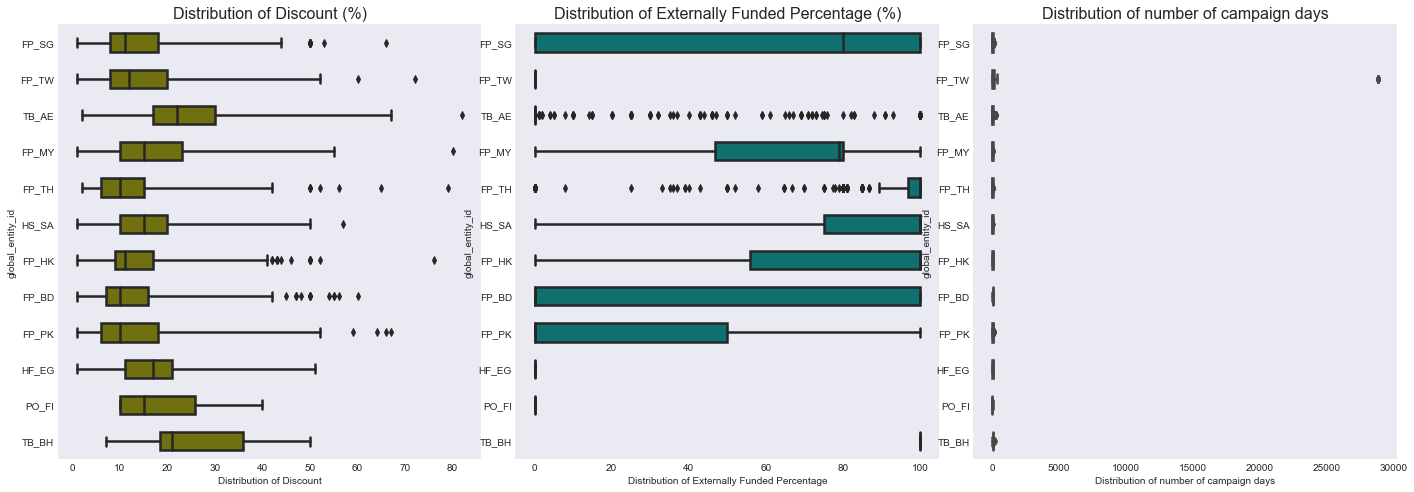

In [39]:
# Choose Columns

category_col = ['global_entity_id']
cols_of_interest = ['discount', 'externally_funded_percentage','number_of_campaign_days']
# Loop through Columns
for cols in cols_of_interest:
    display(df.groupby(category_col)[cols].describe(percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).sort_values(by=['mean'], ascending = False).rename_axis(cols)\
                                                                                                                    .style.format({"count": "{0:.0f}", 
                                                                                                                          "mean": "{0:.2f}", 
                                                                                                                          "std": "{0:.2f}",
                                                                                                                          "min":"{0:.2f}",
                                                                                                                           "1%": "{0:.2f}",
                                                                                                                           "5%": "{0:.2f}",
                                                                                                                          "10%": "{0:.2f}",
                                                                                                                          "25%": "{0:.2f}",
                                                                                                                          "50%": "{0:.2f}",
                                                                                                                          "75%": "{0:.2f}",
                                                                                                                          "90%": "{0:.2f}",
                                                                                                                          "95%": "{0:.2f}",
                                                                                                                         "95%": "{0:.2f}",
                                                                                                                         "99%": "{0:.2f}",
                                                                                                                          "max": "{0:.2f}"})\
                                                                                                                       .background_gradient(cmap='Greens'))

fig, ax = plt.subplots(1,3, figsize = (24,8), sharey=False)
plt.subplots_adjust(wspace = 0.08)

# GMV
sns.boxplot(x = 'discount', y= 'global_entity_id', data = df, ax = ax[0], color = 'olive', whis = 3, width = 0.5, linewidth = 2.5)
ax[0].set_title('Distribution of Discount (%)', fontsize = 16)
ax[0].set_xlabel('Distribution of Discount')

# Quantity Sold
sns.boxplot(x = 'externally_funded_percentage', y= 'global_entity_id', data = df, ax = ax[1], color = 'teal', whis = 3, width = 0.5, linewidth = 2.5)
ax[1].set_title('Distribution of Externally Funded Percentage (%)', fontsize = 16)
ax[1].set_xlabel('Distribution of Externally Funded Percentage')

# Quantity Sold
sns.boxplot(x = 'number_of_campaign_days',y= 'global_entity_id', data = df, ax = ax[2], color = 'crimson', whis = 3, width = 0.5, linewidth = 2.5)
ax[2].set_title('Distribution of number of campaign days', fontsize = 16)
ax[2].set_xlabel('Distribution of number of campaign days')

#### Group Data by Country Level

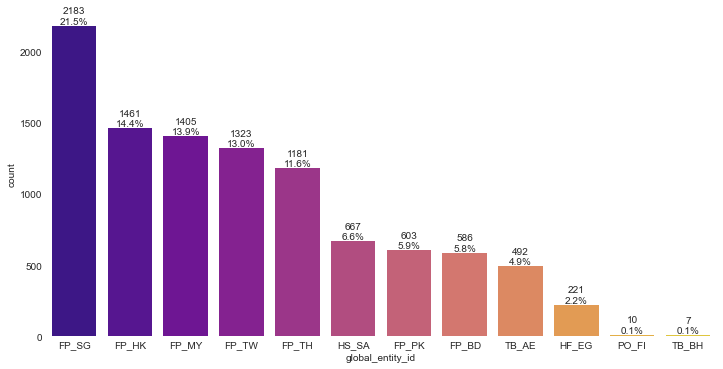

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
viz_utils.single_countplot(df, x='global_entity_id', ax=ax)
plt.show()

In [41]:
countries_agg = df.groupby(by='global_entity_id', as_index=False).agg({'incremental_gmv_tab': 'mean',
                                                                        'incremental_quantity_tab': 'mean',
                                                                        'incremental_profit_ext_tab': 'mean',
                                                                        'discount':'mean',
                                                                        'externally_funded_percentage': 'mean'})
countries_agg.columns = ['country', 'mean_incremental_gmv', 'mean_incremental_quantity', 'mean_incremental_profit_ext', 'mean_discount', 'mean_externally_funded_percentage']
countries_agg = countries_agg.sort_values(by='mean_incremental_profit_ext', ascending=False)
countries_agg = countries_agg.loc[:, ['country', 'mean_incremental_gmv', 'mean_incremental_quantity', 'mean_incremental_profit_ext', 'mean_discount', 'mean_externally_funded_percentage']]
countries_agg.sort_values(by='mean_incremental_profit_ext',ascending = False).reset_index(drop = True).style.set_properties(**{                                                  
                                    'color': 'white',                       
                                    'border-color': 'white'})\
                         .format({"BasePay": "${:20,.0f}", 
                          "mean_incremental_gmv": "{0:.2f}", 
                          "mean_incremental_quantity": "{0:.2f}",
                          "mean_incremental_profit_ext": "{0:.2f}",
                        "mean_discount": "{0:.2f}",                                                                                          
                          "mean_externally_funded_percentage":"{0:.2f}"})\
                 .hide_index()\
                .background_gradient(subset=['mean_incremental_gmv','mean_incremental_quantity','mean_incremental_profit_ext'], cmap='RdYlGn')\
                .background_gradient(subset=['mean_discount', 'mean_externally_funded_percentage'], cmap='Blues')

country,mean_incremental_gmv,mean_incremental_quantity,mean_incremental_profit_ext,mean_discount,mean_externally_funded_percentage
TB_BH,41.35,107.21,107.46,26.71,100.00
FP_TH,22.10,40.77,28.36,11.69,88.98
FP_HK,23.51,46.37,25.52,14.02,75.00
HS_SA,13.98,45.12,23.32,18.22,78.53
FP_SG,21.22,42.09,3.33,13.35,61.96
FP_MY,26.35,57.50,-2.97,17.16,60.18
FP_TW,24.70,53.17,-30.51,15.66,0.00
PO_FI,31.34,67.52,-32.85,20.10,0.00
FP_PK,26.26,54.28,-41.77,12.97,16.89
FP_BD,46.69,75.98,-70.48,13.34,35.60


<AxesSubplot:xlabel='mean_incremental_gmv', ylabel='country'>

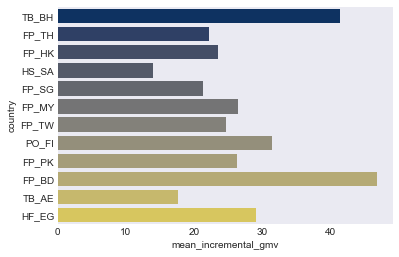

In [42]:
sns.barplot(y = 'country', x = 'mean_incremental_gmv', data = countries_agg, palette = 'cividis')

<AxesSubplot:xlabel='mean_incremental_profit_ext', ylabel='country'>

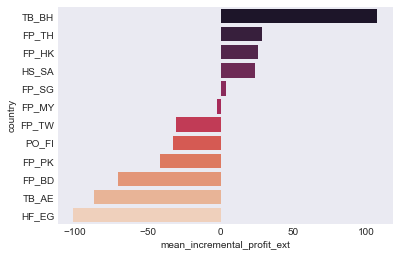

In [43]:
sns.barplot(y = 'country', x = 'mean_incremental_profit_ext', data = countries_agg, palette = 'rocket')

#### Simple Correlation Checks

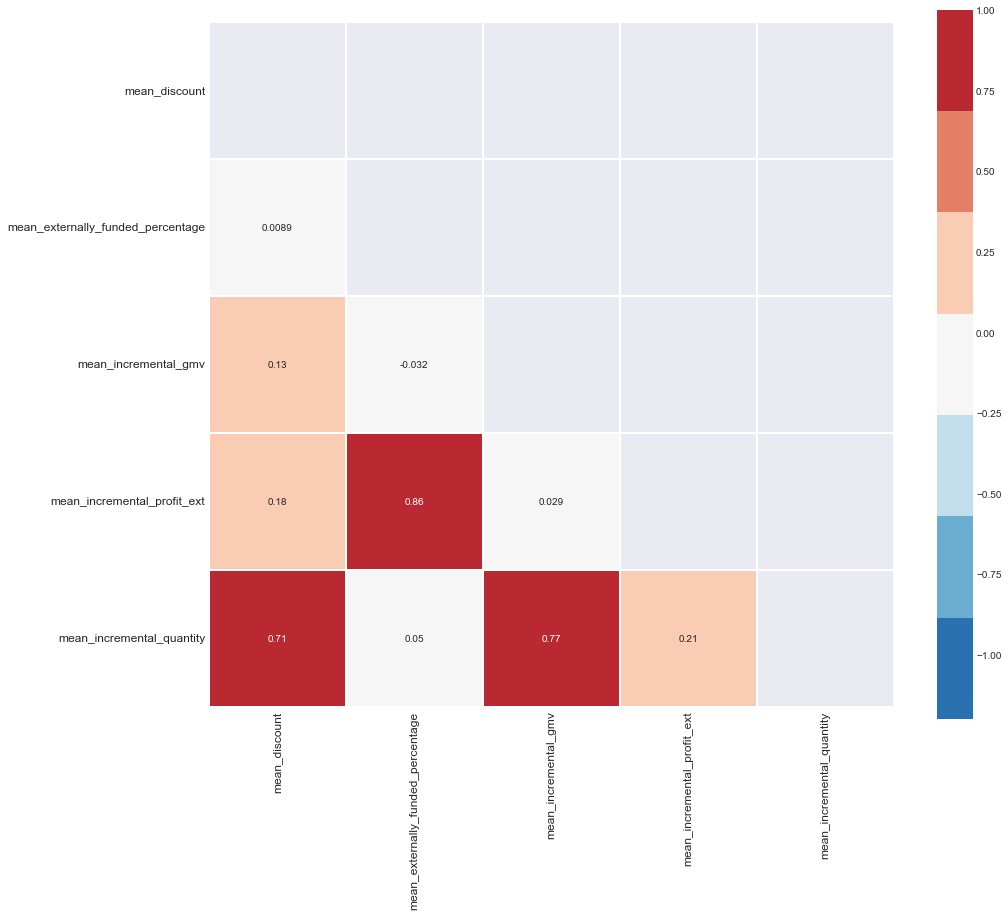

In [44]:
# order columns
rship = countries_agg[countries_agg.columns.sort_values()]

# plot heatmap
mask = np.zeros_like(rship.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

f, ax = plt.subplots(figsize=(15, 20))
sns.heatmap(rship.corr(),
            mask = mask,
            square=True,
            vmin = -1.2,
            vmax = 1,
            linewidth=0.1,
            cbar_kws = {'shrink':0.5},
            cmap=sns.color_palette("RdBu_r", 7), annot=True)
ax.tick_params(labelsize=12)
plt.tight_layout()

#### What correlates most with profitability?

                                   mean_incremental_profit_ext
mean_incremental_profit_ext                           1.000000
mean_externally_funded_percentage                     0.855863
mean_incremental_quantity                             0.210355
mean_discount                                         0.183253
mean_incremental_gmv                                  0.028583


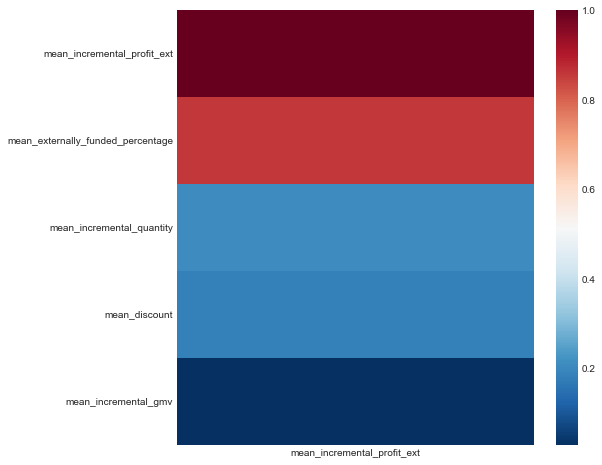

In [45]:
print(np.abs(countries_agg.corr())[['mean_incremental_profit_ext']].sort_values('mean_incremental_profit_ext', ascending=False).head(10))
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(countries_agg.corr()[['mean_incremental_profit_ext']].sort_values('mean_incremental_profit_ext'),
             cmap='RdBu_r', ax=ax);
ax.invert_yaxis()

In [46]:
# Create new columns
df['price_difference'] = df['price_base'] - df['price']
df['y_pred_uplift'] = df['y_pred'] - df['y_pred_base']
df['y_pred_uplift_perc'] = (df['y_pred'] - df['y_pred_base'])/df['y_pred_base'] * 100
df['qty_uplift'] = df['qty_sold'] - df['b_qty']
df['qty_uplift_perc'] = (df['qty_sold'] - df['b_qty'])/df['b_qty'] * 100
df['gmv_uplift'] =  df['gmv'] - df['b_gmv'] 
df['gmv_uplift_perc'] = ((df['gmv'] - df['b_gmv'])/df['b_gmv']) * 100
df['profit_ext_uplift'] = df['profit_ext'] - df['b_profit']
df['profit_ext_uplift_perc'] = ((df['profit_ext'] - df['b_profit'])/df['b_profit']) * 100

#### Rows where the predicted quantity sold baseline (without discount) is higher than what is predicted qty sold (after discount)

In [47]:
print(f'Percentage rows where y_pred_base > y_pred: {np.round(df.query("y_pred_base > y_pred").shape[0]/df.shape[0] * 100,2)}%')
df.query('y_pred_base > y_pred')[['order_date','global_entity_id','campaign_name','product','sku','y_pred_base','y_pred','y_pred_uplift','y_pred_uplift_perc']].sort_values(by=['y_pred_uplift_perc']).head()

Percentage rows where y_pred_base > y_pred: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,y_pred_base,y_pred,y_pred_uplift,y_pred_uplift_perc


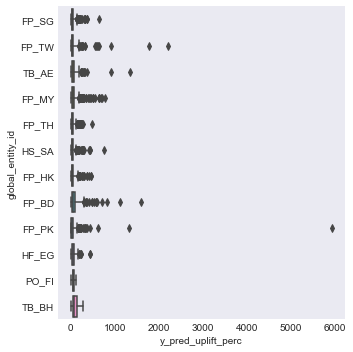

In [48]:
sns.catplot(x='y_pred_uplift_perc', 
            y = 'global_entity_id',
            data=df, 
            kind ='box',
            whis = 3)

In [49]:
df.query('y_pred_uplift_perc > 12000')[['order_date','global_entity_id','campaign_name','product','sku','y_pred_base','y_pred','y_pred_uplift','y_pred_uplift_perc']].sort_values(by=['y_pred_uplift_perc']).head()

,order_date,global_entity_id,campaign_name,product,sku,y_pred_base,y_pred,y_pred_uplift,y_pred_uplift_perc


#### Rows where Price after discount is higher than Price before discount

In [50]:
print(f'Percentage rows where Price > Price_Base: {np.round(df.query("price > price_base").shape[0]/df.shape[0] * 100,2)}%')
df.query("price > price_base")[['order_date','global_entity_id','campaign_name','product','sku','price','price_base','price_difference']].sort_values(by=['price_difference']).head()

Percentage rows where Price > Price_Base: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,price,price_base,price_difference


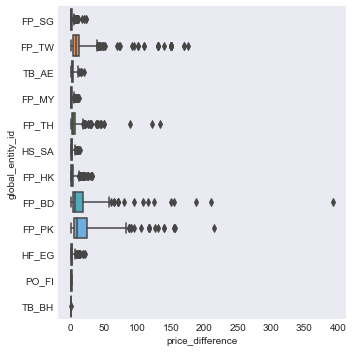

In [51]:
sns.catplot(x='price_difference', 
            y = 'global_entity_id',
            data=df, 
            kind ='box',
            whis = 3)

In [52]:
df.query("price_difference > 400")[['order_date','global_entity_id','campaign_name','product','sku','price','price_base','price_difference']].sort_values(by=['price_difference']).head()

,order_date,global_entity_id,campaign_name,product,sku,price,price_base,price_difference


#### Rows where Baseline Quantity > Quantity Sold

In [53]:
print(f'Percentage rows where Baseline Quantity > Quantity: {np.round(df.query("b_qty > qty_sold").shape[0]/df.shape[0] * 100,2)}%')
df.query("b_qty > qty_sold")[['order_date','global_entity_id','campaign_name','product','sku','qty_sold','b_qty','qty_uplift','qty_uplift_perc']].sort_values(by=['qty_uplift_perc']).head()

Percentage rows where Baseline Quantity > Quantity: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,qty_sold,b_qty,qty_uplift,qty_uplift_perc


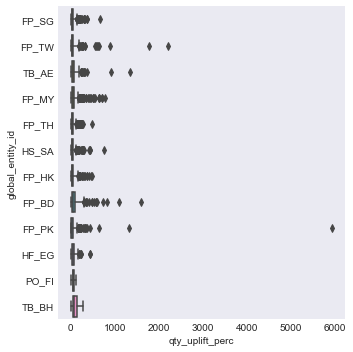

In [54]:
sns.catplot(x='qty_uplift_perc', 
            y = 'global_entity_id',
            data=df, 
            kind ='box',
            whis = 3)

In [55]:
df.query("qty_uplift_perc > 8000")[['order_date','global_entity_id','campaign_name','product','sku','qty_sold','b_qty','qty_uplift','qty_uplift_perc']].sort_values(by=['qty_uplift_perc'], ascending = False).head()

,order_date,global_entity_id,campaign_name,product,sku,qty_sold,b_qty,qty_uplift,qty_uplift_perc


#### Rows where Baseline GMV > GMV

In [56]:
print(f'Percentage rows where Baseline GMV > GMV: {np.round(df.query("b_gmv > gmv").shape[0]/df.shape[0] * 100,2)}%')
df.query("b_gmv > gmv")[['order_date','global_entity_id','campaign_name','product','sku','gmv','b_gmv','gmv_uplift','gmv_uplift_perc']].sort_values(by=['gmv_uplift_perc']).head()

Percentage rows where Baseline GMV > GMV: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,gmv,b_gmv,gmv_uplift,gmv_uplift_perc


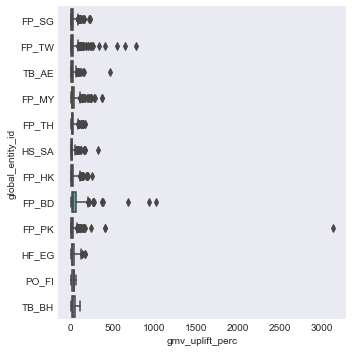

In [57]:
sns.catplot(x='gmv_uplift_perc', 
            y = 'global_entity_id',
            data=df, 
            kind ='box',
            whis = 3)

In [58]:
df.query('gmv_uplift_perc > 3000')[['global_entity_id','product','sku','campaign_name','b_gmv','gmv','gmv_uplift','gmv_uplift_perc']].sort_values(by=['gmv_uplift_perc'], ascending = False).head()

,global_entity_id,product,sku,campaign_name,b_gmv,gmv,gmv_uplift,gmv_uplift_perc
6680,FP_PK,Cappy Pulpy Orange 350ml,UKY241,Coca Cola Liquidation - Lahore - With Banner,418.04,13471.2,13053.16,3122.46675


#### Rows where b_profit > profit_ext

In [59]:
print(f'Percentage rows where Baseline Profit > Profit External: {np.round(df.query("b_profit > profit_ext").shape[0]/df.shape[0] * 100,2)}%')
df.query("b_profit > profit_ext")[['order_date','global_entity_id','campaign_name','product','sku','profit','profit_ext','b_profit','profit_ext_uplift','profit_ext_uplift_perc','incremental_profit_ext_tab']].sort_values(by=['profit_ext_uplift_perc']).tail()

Percentage rows where Baseline Profit > Profit External: 42.38%


,order_date,global_entity_id,campaign_name,product,sku,profit,profit_ext,b_profit,profit_ext_uplift,profit_ext_uplift_perc,incremental_profit_ext_tab
6990,2021-10-14,TB_AE,UAE_Tmart Giri KAF Produce Banner 20K [CLONE],Ginger China 500 g,900781,-0.37,-0.37,-0.06,-0.31,516.666667,516.666667
5673,2021-09-03,FP_PK,Mix Assortment Strikethrough - Without Banner - Nationwide,Dawn White Bread Vitamin Enriched Medium,736YZR,-102.00,-102.00,-15.53,-86.47,556.793303,556.793303
1346,2021-06-15,FP_BD,Monthly_Breakfast___flat__All_WK1_May21_V1[CLONE][CLONE][CLONE][CLONE],ACI Pure Premium Atta | 1 kg,Q883YA,-1.18,-1.18,-0.16,-1.02,637.500000,637.500000
3519,2021-03-17,HF_EG,Fresh Food - Ramadan W1[CLONE],President Triangle Cheese 16 Pcs,901575,-9.93,-9.93,-0.83,-9.10,1096.385542,1096.385542
806,2020-12-12,TB_AE,UAE -50% Off December Flash Sale -All Stores,Dettol Skin Care Bar Soap 165 Gm,900509,-14.80,-14.80,-0.69,-14.11,2044.927536,2044.927536


#### Rows where Profit > Profit with External Funding

In [60]:
df['external_funding_calc_from_profit'] = df['profit_ext'] - df['profit']
print(f'Percentage rows where Profit > Profit with External Funding: {np.round(df.query("profit > profit_ext").shape[0]/df.shape[0] * 100,2)}%')
df.query("profit > profit_ext")[['order_date','global_entity_id','campaign_name','product','sku','profit','profit_ext','external_funding_calc_from_profit', 'externally_funded_percentage']].sort_values(by=['external_funding_calc_from_profit']).head()

Percentage rows where Profit > Profit with External Funding: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,profit,profit_ext,external_funding_calc_from_profit,externally_funded_percentage


#### Rows where Discounts > 100

In [61]:
print(f'Percentage rows where Discount > 100: {np.round(df.query("discount > 100").shape[0]/df.shape[0] * 100,4)}%')
df.query("discount > 100")[['order_date','global_entity_id','campaign_name','product','sku','discount']].sort_values(by=['discount'],ascending = False).head()

Percentage rows where Discount > 100: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,discount


#### Rows where Externally Funded Percentage > 100

In [62]:
print(f'Percentage rows where Externally Funded Percentage > 100: {np.round(df.query("externally_funded_percentage > 100").shape[0]/df.shape[0] * 100,2)}%')
df.query("externally_funded_percentage > 100")[['order_date','global_entity_id','campaign_name','product','sku','externally_funded_percentage']].sort_values(by=['externally_funded_percentage'],ascending = False).head()

Percentage rows where Externally Funded Percentage > 100: 0.0%


,order_date,global_entity_id,campaign_name,product,sku,externally_funded_percentage


#### Rows where Creation of campaign is after is start date

In [63]:
df['no_of_days_created_after_start'] = (df['campaign_created_time_utc'] - df['campaign_start_time_utc']).dt.days

In [64]:
df.query("no_of_days_created_after_start > 3")[['order_date','global_entity_id','campaign_name','product','sku','campaign_created_time_utc','campaign_start_time_utc','no_of_days_created_after_start']].sort_values(by=['campaign_created_time_utc'], 
ascending = False).head()

,order_date,global_entity_id,campaign_name,product,sku,campaign_created_time_utc,campaign_start_time_utc,no_of_days_created_after_start


#### Great Expectations

In [65]:
import great_expectations as ge

ModuleNotFoundError: No module named 'great_expectations'

In [ ]:
my_df = ge.from_pandas(df)

In [ ]:
my_df.expect_column_values_to_be_between(['discount'],0,100)

{
  "meta": {},
  "success": true,
  "result": {
    "element_count": 10167,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 1,
    "unexpected_percent": 0.009835743090390479,
    "unexpected_percent_total": 0.009835743090390479,
    "unexpected_percent_nonmissing": 0.009835743090390479,
    "partial_unexpected_list": [
      "discount"
    ]
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

In [ ]:
df.query("discount > 100")[['order_date','global_entity_id','campaign_name','product','sku','discount']].sort_values(by=['discount'],ascending = False).head()

,order_date,global_entity_id,campaign_name,product,sku,discount


In [ ]:
# Qty_sold should be greater than Baseline Quantity
my_df.expect_column_pair_values_A_to_be_greater_than_B("qty_sold", "b_qty",or_equal = True)

{
  "meta": {},
  "success": true,
  "result": {
    "element_count": 10167,
    "missing_count": 0,
    "missing_percent": 0.0,
    "unexpected_count": 0,
    "unexpected_percent": 0.0,
    "unexpected_percent_total": 0.0,
    "unexpected_percent_nonmissing": 0.0,
    "partial_unexpected_list": []
  },
  "exception_info": {
    "raised_exception": false,
    "exception_traceback": null,
    "exception_message": null
  }
}

In [ ]:
my_df.get_expectation_suite(discard_failed_expectations=False)

{
  "meta": {
    "great_expectations_version": "0.13.41"
  },
  "data_asset_type": "Dataset",
  "expectations": [
    {
      "expectation_type": "expect_column_values_to_be_between",
      "meta": {},
      "kwargs": {
        "column": [
          "discount"
        ],
        "min_value": 0,
        "max_value": 100
      },
      "ge_cloud_id": null
    },
    {
      "expectation_type": "expect_column_pair_values_A_to_be_greater_than_B",
      "meta": {},
      "kwargs": {
        "column_A": "qty_sold",
        "column_B": "b_qty",
        "or_equal": true
      },
      "ge_cloud_id": null
    }
  ],
  "ge_cloud_id": null,
  "expectation_suite_name": "default"
}